In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.8 MB/s eta 0:00:00


# QFT of a signal with 1 Tone

Using frequencies: [2]
Phase encoding mode: single_tone_exact

Circuit (W → H⊗n → PHASE ENCODING → QFT → SWAPs → R):
      W ┌────┐┌─────────────────┐ DFT1                                       ┌──────┐ DFT2                               ┌──────┐ DFT3                         ┌───────┐ DFT4                 ┌───────┐»
q_0: ─░─┤ H1 ├┤0                ├──░─────────────────────────────────────────┤1     ├──░─────────────────────────────────┤1     ├──░───────────────────────────┤1      ├──░───────────────────┤1      ├»
      ░ ├────┤│                 │  ░                                 ┌──────┐│      │  ░                         ┌──────┐│      │  ░                  ┌───────┐│       │  ░          ┌───────┐│       │»
q_1: ─░─┤ H2 ├┤1                ├──░─────────────────────────────────┤1     ├┤      ├──░─────────────────────────┤1     ├┤      ├──░──────────────────┤1      ├┤       ├──░──────────┤1      ├┤  Cφ14 ├»
      ░ ├────┤│                 │  ░                         ┌──────┐│      ││ 

/tmp/ipython-input-1896637434.py:105: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.diagonal.Diagonal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use DiagonalGate instead.
  gate = Diagonal(diag).to_gate()


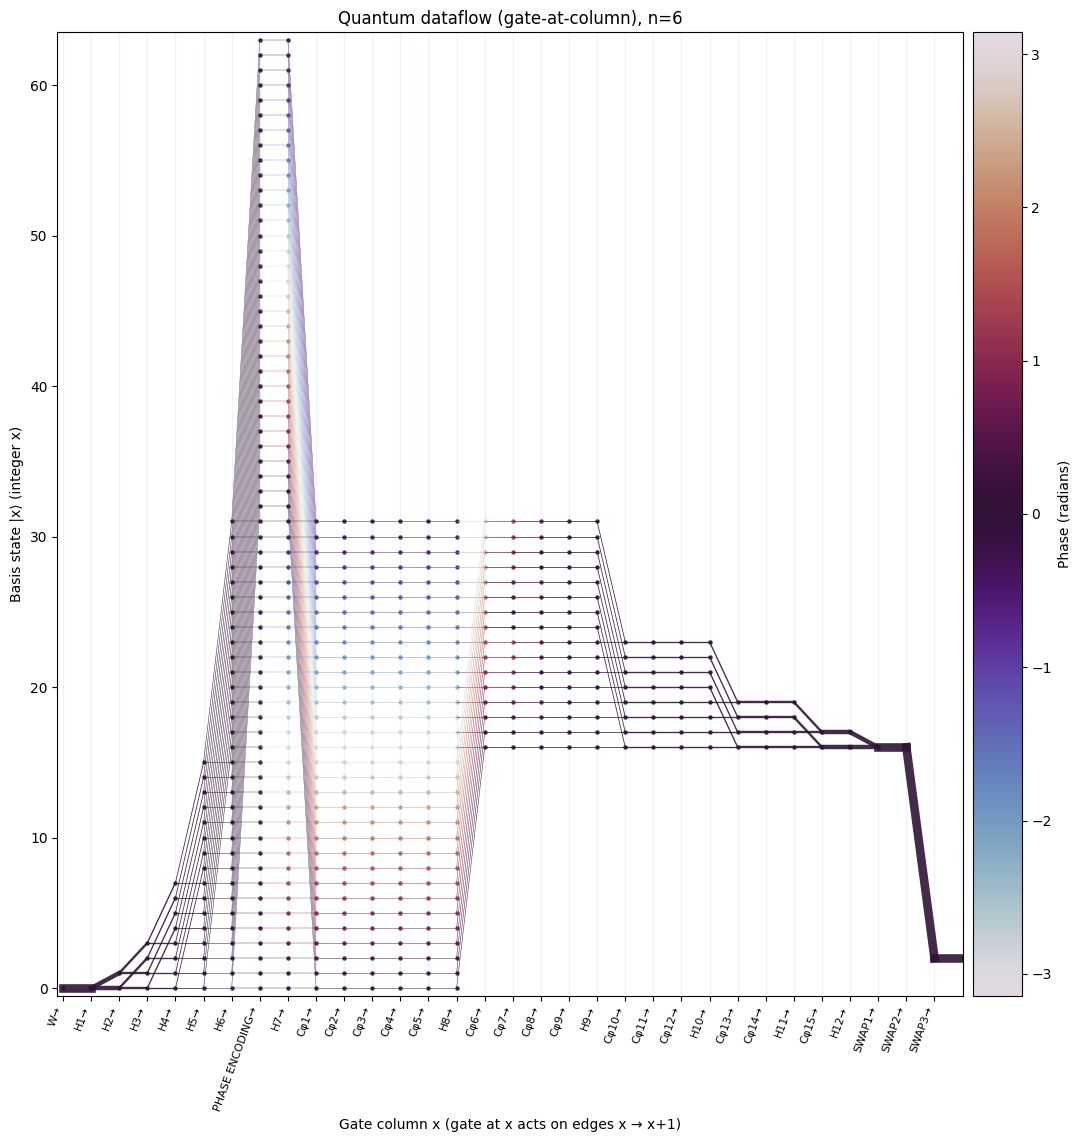

In [46]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt


# =============================================================================
# Frequency + phase helpers
# =============================================================================

def pick_frequencies(num_qubits: int, num_frequencies: int, *, single_tone_default: int = 2) -> List[int]:
    N = 1 << num_qubits
    if num_frequencies <= 0:
        return []
    if num_frequencies == 1:
        return [int(single_tone_default) % N]
    out = [(f % N) for f in range(1, num_frequencies + 1)]
    seen, uniq = set(), []
    for f in out:
        if f not in seen:
            uniq.append(f)
            seen.add(f)
    return uniq


def phase_profile(num_qubits: int, freqs: Sequence[int], *, mode: str = "single_tone_exact") -> np.ndarray:
    N = 1 << num_qubits
    x = np.arange(N, dtype=float)
    freqs = [int(f) for f in freqs]

    if len(freqs) == 0:
        return np.zeros(N, dtype=float)

    if mode == "single_tone_exact":
        f = int(freqs[0])
        phi = +2.0 * math.pi * f * x / N
        return (phi + math.pi) % (2.0 * math.pi) - math.pi

    if mode == "multi_tone_phase_only":
        z = np.zeros(N, dtype=complex)
        for f in freqs:
            z += np.exp(+1j * 2.0 * math.pi * f * x / N)
        return np.angle(z)

    raise ValueError(f"Unknown phase mode: {mode}")

# used to encode the phase in the signal
def diagonal_from_phase(phi: np.ndarray) -> np.ndarray:
    return np.exp(1j * phi)


# =============================================================================
# Qiskit circuit construction
# =============================================================================

def require_qiskit():
    try:
        from qiskit import QuantumCircuit  # type: ignore
        from qiskit.circuit import QuantumRegister, ClassicalRegister  # type: ignore
        return QuantumCircuit, QuantumRegister, ClassicalRegister
    except Exception as e:
        raise ImportError("Qiskit is required. Install with: pip install qiskit") from e


def labeled_gate_from_subcircuit(sub_qc, label: str):
    g = sub_qc.to_gate()
    g.label = label
    return g


def make_labeled_H(label: str):
    QuantumCircuit, _, _ = require_qiskit()
    sub = QuantumCircuit(1)
    sub.h(0)
    return labeled_gate_from_subcircuit(sub, label)


def make_labeled_CP(angle: float, label: str):
    QuantumCircuit, _, _ = require_qiskit()
    sub = QuantumCircuit(2)
    sub.cp(angle, 0, 1)
    return labeled_gate_from_subcircuit(sub, label)


def make_labeled_SWAP(label: str):
    QuantumCircuit, _, _ = require_qiskit()
    sub = QuantumCircuit(2)
    sub.swap(0, 1)
    return labeled_gate_from_subcircuit(sub, label)


def build_phase_encoding_gate(num_qubits: int, freqs: Sequence[int], *, phase_mode: str):
    phi = phase_profile(num_qubits, freqs, mode=phase_mode)
    diag = diagonal_from_phase(phi)

    try:
        from qiskit.circuit.library import Diagonal  # type: ignore
    except Exception as e:
        raise ImportError("Need qiskit.circuit.library.Diagonal for phase encoding.") from e

    gate = Diagonal(diag).to_gate()
    gate.label = "PHASE ENCODING"
    return gate


def build_qft_paper_labeled(
    num_qubits: int,
    *,
    start_H_index: int,
    start_Cphi_index: int,
    do_swaps: bool = True,
    include_dft_markers_in_circuit: bool = True,
):

    QuantumCircuit, _, _ = require_qiskit()
    qc = QuantumCircuit(num_qubits, name="QFT")

    H_i = start_H_index
    C_i = start_Cphi_index
    dft_block = 1

    for j in range(num_qubits - 1, -1, -1):  # MSB -> LSB
        if include_dft_markers_in_circuit:
            try:
                qc.barrier(label=f"DFT{dft_block}")
            except TypeError:
                qc.barrier()

        # H first (join/fork)
        qc.append(make_labeled_H(f"H{H_i}"), [j])
        H_i += 1

        # Then CP ladder to LOWER qubits with NEGATIVE angles
        for m in range(j - 1, -1, -1):
            d = j - m
            angle = -math.pi / (2 ** d)
            qc.append(make_labeled_CP(angle, f"Cφ{C_i}"), [j, m])  # (j,m) matches your description
            C_i += 1

        dft_block += 1

    # SWAPs only (no separate "Qubit Reversal" label)
    if do_swaps:
        sidx = 1
        for i in range(num_qubits // 2):
            a, b = i, num_qubits - 1 - i
            qc.append(make_labeled_SWAP(f"SWAP{sidx}"), [a, b])
            sidx += 1

    return qc, H_i, C_i


def build_full_circuit_paper(
    num_qubits: int,
    num_frequencies: int,
    *,
    freqs: Optional[Sequence[int]] = None,
    phase_mode: str = "single_tone_exact",
    add_measurement_R: bool = True,
    include_dft_markers_in_circuit: bool = True,
):
    QuantumCircuit, QuantumRegister, ClassicalRegister = require_qiskit()

    if freqs is None:
        freqs = pick_frequencies(num_qubits, num_frequencies)

    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(num_qubits, "c") if add_measurement_R else None
    qc = QuantumCircuit(q, c) if c is not None else QuantumCircuit(q)

    try:
        qc.barrier(label="W")
    except TypeError:
        qc.barrier()

    # H1..Hn (state preparation)
    for i in range(num_qubits):
        qc.append(make_labeled_H(f"H{i+1}"), [q[i]])

    # PHASE ENCODING
    pe = build_phase_encoding_gate(num_qubits, freqs, phase_mode=phase_mode)
    qc.append(pe, list(q))

    # QFT (paper order/sign)
    qft_sub, _, _ = build_qft_paper_labeled(
        num_qubits,
        start_H_index=num_qubits + 1,  # H_{n+1}..H_{2n}
        start_Cphi_index=1,
        do_swaps=True,
        include_dft_markers_in_circuit=include_dft_markers_in_circuit,
    )
    qc.compose(qft_sub, qubits=list(q), inplace=True)

    if add_measurement_R and c is not None:
        try:
            qc.barrier(label="R")
        except TypeError:
            qc.barrier()
        qc.measure(q, c)

    return qc, list(freqs)


def plot_circuit(qc):
    try:
        fig = qc.draw(output="mpl", fold=-1)
        plt.show()
        return fig
    except Exception:
        print(qc.draw(output="text", fold=200))
        return None


# =============================================================================
# Quantum dataflow
# =============================================================================

@dataclass(frozen=True)
class Edge:
    src: int
    dst: int
    weight: float
    phase: float


@dataclass(frozen=True)
class Step:
    label: str
    kind: str  # 'W', 'H', 'CP', 'SWAP', 'DIAG'
    qargs: Tuple[int, ...] = ()
    angle: float = 0.0
    diag: Optional[np.ndarray] = None


def _apply_h(state: np.ndarray, num_qubits: int, q: int, *, amp_epsilon: float = 1e-15):
    """
    Hadamard edges weighted by destination probabilities |out|^2
    to avoid stray edges from destructive interference.
    """
    N = 1 << num_qubits
    inv_sqrt2 = 1.0 / math.sqrt(2.0)
    out = state.copy()
    edges = []
    bit = 1 << q

    for i in range(N):
        if i & bit:
            continue
        j = i | bit

        ai, aj = state[i], state[j]

        oi = (ai + aj) * inv_sqrt2
        oj = (ai - aj) * inv_sqrt2

        if abs(oi) < amp_epsilon:
            oi = 0.0 + 0.0j
        if abs(oj) < amp_epsilon:
            oj = 0.0 + 0.0j

        out[i] = oi
        out[j] = oj

        p_oi = float(abs(oi) ** 2)
        p_oj = float(abs(oj) ** 2)

        c_i = float(abs(ai) ** 2) * 0.5
        c_j = float(abs(aj) ** 2) * 0.5
        total = c_i + c_j
        if total <= 0.0:
            continue

        if p_oi > 0.0:
            edges.append((i, i, p_oi * (c_i / total)))
            edges.append((j, i, p_oi * (c_j / total)))
        if p_oj > 0.0:
            edges.append((i, j, p_oj * (c_i / total)))
            edges.append((j, j, p_oj * (c_j / total)))

    return out, edges


def _apply_cp(state: np.ndarray, num_qubits: int, control: int, target: int, angle: float):
    N = 1 << num_qubits
    out = state.copy()
    edges = []
    cbit, tbit = 1 << control, 1 << target
    phase = np.exp(1j * angle)

    for i in range(N):
        edges.append((i, i, float(abs(state[i]) ** 2)))
        if (i & cbit) and (i & tbit):
            out[i] *= phase

    return out, edges


def _swap_bits(i: int, q1: int, q2: int) -> int:
    if q1 == q2:
        return i
    b1 = (i >> q1) & 1
    b2 = (i >> q2) & 1
    if b1 == b2:
        return i
    return i ^ ((1 << q1) | (1 << q2))


def _apply_swap(state: np.ndarray, num_qubits: int, q1: int, q2: int):
    N = 1 << num_qubits
    out = np.zeros_like(state)
    edges = []
    for i in range(N):
        j = _swap_bits(i, q1, q2)
        out[j] = state[i]
        edges.append((i, j, float(abs(state[i]) ** 2)))
    return out, edges


def _apply_diag(state: np.ndarray, diag: np.ndarray):
    out = state * diag
    edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(state.size)]
    return out, edges


def build_dataflow_steps_paper(
    num_qubits: int,
    freqs: Sequence[int],
    *,
    phase_mode: str = "single_tone_exact",
    do_swaps: bool = True,
) -> List[Step]:

    steps: List[Step] = [Step(label="W", kind="W")]

    # H1..Hn
    for q in range(num_qubits):
        steps.append(Step(label=f"H{q+1}", kind="H", qargs=(q,)))

    # PHASE ENCODING
    phi = phase_profile(num_qubits, freqs, mode=phase_mode)
    steps.append(Step(label="PHASE ENCODING", kind="DIAG", diag=diagonal_from_phase(phi)))

    # QFT: paper order/sign
    H_i = num_qubits + 1
    C_i = 1
    for j in range(num_qubits - 1, -1, -1):  # MSB -> LSB
        steps.append(Step(label=f"H{H_i}", kind="H", qargs=(j,)))
        H_i += 1
        for m in range(j - 1, -1, -1):
            d = j - m
            angle = -math.pi / (2 ** d)  # -90°, -45°, ...
            steps.append(Step(label=f"Cφ{C_i}", kind="CP", qargs=(j, m), angle=angle))
            C_i += 1

    # SWAPs only
    if do_swaps:
        sidx = 1
        for i in range(num_qubits // 2):
            a, b = i, num_qubits - 1 - i
            steps.append(Step(label=f"SWAP{sidx}", kind="SWAP", qargs=(a, b)))
            sidx += 1

    return steps


def simulate_dataflow(num_qubits: int, steps: Sequence[Step], *, amp_epsilon: float = 1e-15):

    N = 1 << num_qubits
    state = np.zeros(N, dtype=complex)
    state[0] = 1.0 + 0.0j

    states: List[np.ndarray] = [state.copy()]
    edges_by_step: List[List[Edge]] = []

    for s in steps:
        if s.kind == "H":
            new_state, raw_edges = _apply_h(state, num_qubits, s.qargs[0], amp_epsilon=amp_epsilon)
        elif s.kind == "CP":
            c, t = s.qargs
            new_state, raw_edges = _apply_cp(state, num_qubits, c, t, s.angle)
        elif s.kind == "SWAP":
            new_state, raw_edges = _apply_swap(state, num_qubits, s.qargs[0], s.qargs[1])
        elif s.kind == "DIAG":
            assert s.diag is not None
            new_state, raw_edges = _apply_diag(state, s.diag)
        elif s.kind == "W":
            new_state = state.copy()
            raw_edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(N)]
        else:
            raise ValueError(f"Unsupported step kind: {s.kind}")

        new_state = new_state.copy()
        new_state[np.abs(new_state) < amp_epsilon] = 0.0 + 0.0j

        dest_phase = np.zeros(N, dtype=float)
        mask = np.abs(new_state) >= amp_epsilon
        dest_phase[mask] = np.angle(new_state[mask])

        edges_by_step.append([
            Edge(src=i, dst=j, weight=w, phase=float(dest_phase[j]))
            for (i, j, w) in raw_edges
        ])

        state = new_state
        states.append(state.copy())

    return states, edges_by_step


def plot_quantum_dataflow(
    num_qubits: int,
    steps: Sequence[Step],
    states: Sequence[np.ndarray],
    edges_by_step: Sequence[Sequence[Edge]],
    *,
    max_states_to_plot: int = 64,
    prob_threshold: float = 1e-12,
    edge_threshold: float = 1e-12,
    show_step_columns: bool = True,
):

    N = 1 << num_qubits
    ncols = len(steps) + 1

    # Choose which basis states to show (by max probability over time)
    if max_states_to_plot >= N:
        keep = np.arange(N, dtype=int)
    else:
        all_probs = np.stack([np.abs(s) ** 2 for s in states], axis=0)
        importance = np.max(all_probs, axis=0)
        keep = np.argsort(importance)[::-1][:max_states_to_plot]
        keep = np.sort(keep)
    keep_set = set(int(x) for x in keep)

    # Normalize linewidths
    max_w = 0.0
    for edges in edges_by_step:
        for e in edges:
            if e.src in keep_set and e.dst in keep_set and e.weight > edge_threshold:
                max_w = max(max_w, e.weight)
    if max_w == 0.0:
        max_w = 1.0

    fig, ax = plt.subplots(figsize=(max(11.0, 0.35 * ncols), max(6.0, 0.18 * len(keep))))
    cmap = plt.get_cmap("twilight")

    # Draw faint vertical lines at gate columns (helps attribution)
    if show_step_columns:
        for x in range(len(steps)):
            ax.axvline(x, linewidth=1.0, alpha=0.08)

    # Edges: step i from x=i -> x=i+1
    for i, edges in enumerate(edges_by_step):
        for e in edges:
            if e.src not in keep_set or e.dst not in keep_set:
                continue
            if e.weight <= edge_threshold:
                continue
            phase_norm = (e.phase + math.pi) / (2.0 * math.pi)
            lw = 0.2 + 6.0 * (e.weight / max_w)
            ax.plot([i, i + 1], [e.src, e.dst], linewidth=lw, color=cmap(phase_norm), alpha=0.9)

    # Nodes (state amplitudes) at each column
    for x in range(len(states)):
        probs = np.abs(states[x]) ** 2
        ph = np.angle(states[x])
        for b in keep:
            if probs[b] <= prob_threshold:
                continue
            ax.scatter([x], [b], s=10,
                       color=cmap((ph[b] + math.pi) / (2.0 * math.pi)),
                       alpha=0.95, linewidths=0)

    ax.set_title(f"Quantum dataflow (gate-at-column), n={num_qubits}")
    ax.set_xlabel("Gate column x (gate at x acts on edges x → x+1)")
    ax.set_ylabel("Basis state |x⟩ (integer x)")
    ax.set_xlim(-0.2, ncols - 1)  # tiny padding so x=0 label isn't cramped
    ax.set_ylim(min(keep) - 0.5, max(keep) + 0.5)

    # Label only the gate columns (0..len(steps)-1). Final column is unlabeled.
    ax.set_xticks(range(0, len(steps)))
    # Optional arrow suffix helps the brain: label belongs to edges to the right
    ax.set_xticklabels([f"{s.label}→" for s in steps], rotation=70, ha="right", fontsize=8)

    # Phase colorbar
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=-math.pi, vmax=math.pi)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Phase (radians)")

    fig.tight_layout()
    plt.show()
    return fig, ax



def print_final_peaks(states: Sequence[np.ndarray], num_qubits: int, *, top_k: int = 8):
    final = states[-1]
    probs = np.abs(final) ** 2
    order = np.argsort(probs)[::-1]
    print("\nFinal measurement distribution (top outcomes):")
    for i in order[:top_k]:
        if probs[i] < 1e-12:
            break
        print(f"  |{i}⟩  bin={format(i, f'0{num_qubits}b')}  prob={probs[i]:.6f}  phase={np.angle(final[i]):+.3f} rad")


def run(
    num_qubits: int,
    num_frequencies: int,
    *,
    freqs: Optional[Sequence[int]] = None,
    phase_mode: str = "single_tone_exact",
    max_states_to_plot: int = 64,
    amp_epsilon: float = 1e-15,
    include_dft_markers_in_circuit: bool = True,
):
    if freqs is None:
        freqs = pick_frequencies(num_qubits, num_frequencies)

    print(f"Using frequencies: {list(freqs)}")
    print(f"Phase encoding mode: {phase_mode}")

    # Circuit diagram
    qc, _ = build_full_circuit_paper(
        num_qubits,
        num_frequencies,
        freqs=freqs,
        phase_mode=phase_mode,
        add_measurement_R=True,
        include_dft_markers_in_circuit=include_dft_markers_in_circuit,
    )
    print("\nCircuit (W → H⊗n → PHASE ENCODING → QFT → SWAPs → R):")
    plot_circuit(qc)

    # Dataflow
    steps = build_dataflow_steps_paper(
        num_qubits,
        freqs,
        phase_mode=phase_mode,
        do_swaps=True,
    )
    states, edges = simulate_dataflow(num_qubits, steps, amp_epsilon=amp_epsilon)
    print_final_peaks(states, num_qubits=num_qubits, top_k=min(8, 1 << num_qubits))
    plot_quantum_dataflow(
        num_qubits,
        steps,
        states,
        edges,
        max_states_to_plot=max_states_to_plot,
        prob_threshold=1e-12,
        edge_threshold=1e-12,
    )


if __name__ == "__main__":
    # Single tone f=2 (expects a single peak at |2⟩ with this paper-sign QFT)
    run(
        num_qubits=6,
        num_frequencies=1,
        freqs=[2],
        phase_mode="single_tone_exact",
        max_states_to_plot=64,
        amp_epsilon=1e-15,
        include_dft_markers_in_circuit=True,
    )


# QFT of Square Wave Odd Harmonics

/tmp/ipython-input-263758005.py:98: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.diagonal.Diagonal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use DiagonalGate instead.
  gate = Diagonal(diag).to_gate()



--- Circuit diagram ---
      W ┌────┐┌─────────────────┐                                                                  ┌──────┐                 ┌──────┐                ┌───────┐         ┌───────┐          ┌───────┐»
q_0: ─░─┤ H1 ├┤0                ├──────────────────────────────────────────────────────────────────┤1     ├─────────────────┤1     ├────────────────┤1      ├─────────┤1      ├──────────┤1      ├»
      ░ ├────┤│                 │                                            ┌──────┐              │      │┌──────┐         │      │┌───────┐       │       │┌───────┐│       │ ┌─────┐  │  Cφ15 │»
q_1: ─░─┤ H2 ├┤1                ├────────────────────────────────────────────┤1     ├──────────────┤      ├┤1     ├─────────┤      ├┤1      ├───────┤       ├┤1      ├┤  Cφ14 ├─┤ H11 ├──┤0      ├»
      ░ ├────┤│                 │                            ┌──────┐        │      │┌──────┐      │      ││      │┌───────┐│      ││       │┌─────┐│  Cφ12 ││  Cφ13 ││       │┌┴─────┴─┐└─────

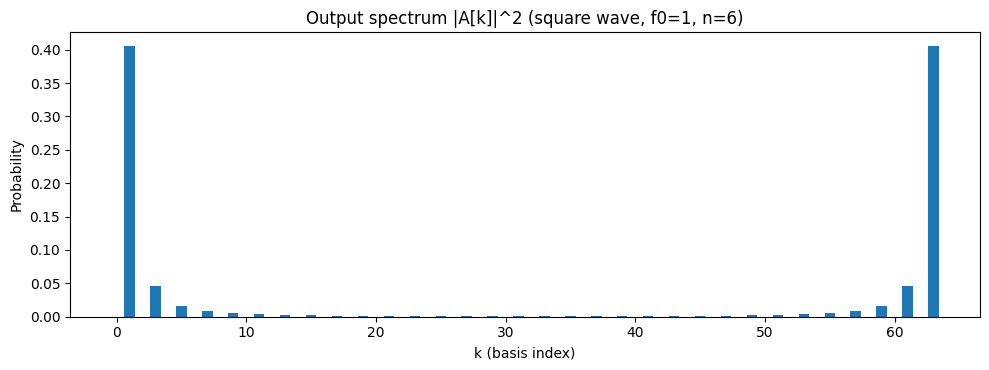


--- Quantum dataflow diagram (paper-matching QFT, no DFT labels) ---


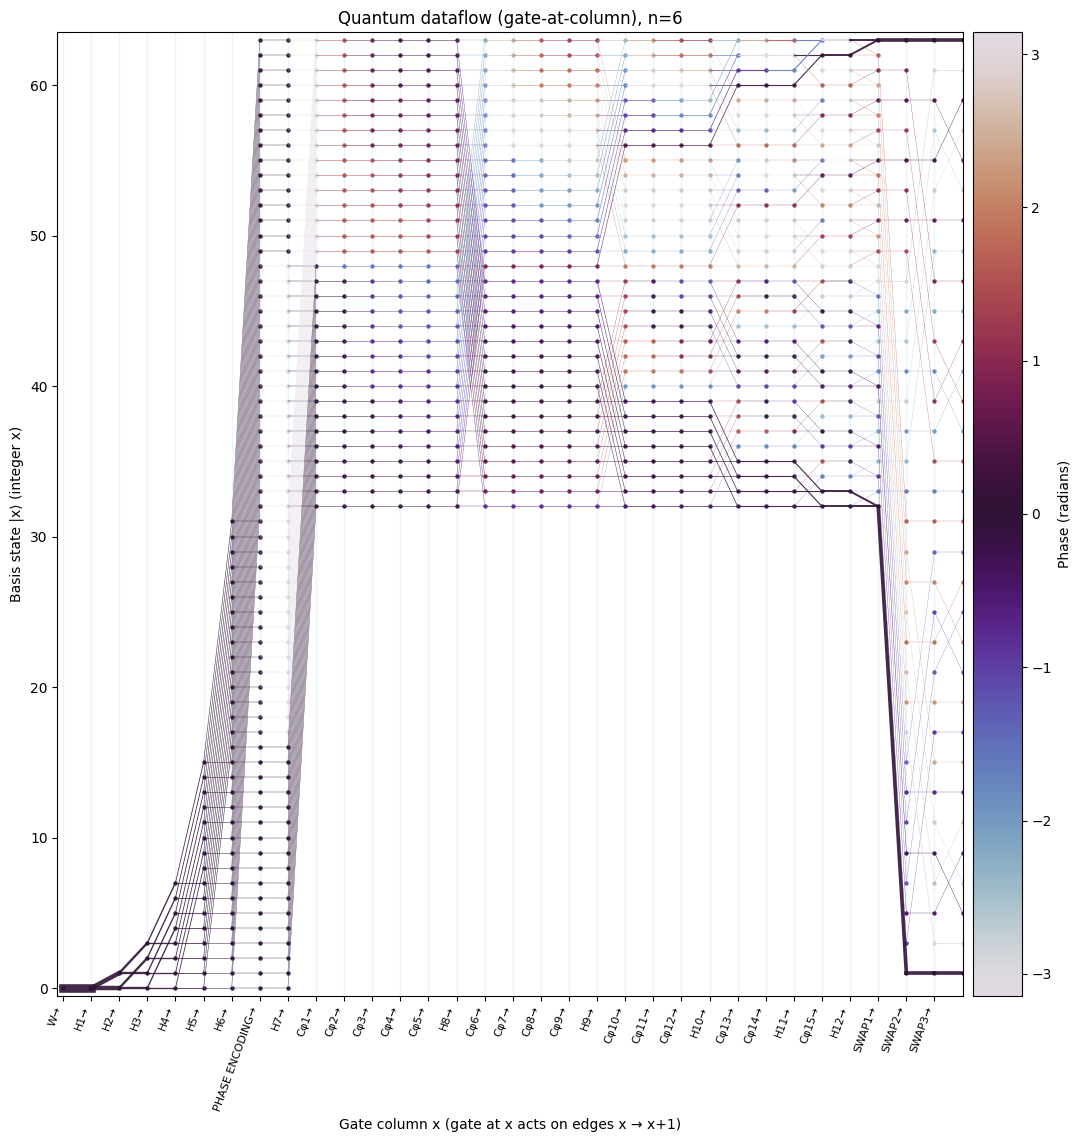

In [29]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Qiskit helpers (circuit + drawing + statevector)
# ============================================================

def require_qiskit():
    try:
        from qiskit import QuantumCircuit
        from qiskit.circuit import QuantumRegister, ClassicalRegister
        from qiskit.quantum_info import Statevector
        return QuantumCircuit, QuantumRegister, ClassicalRegister, Statevector
    except Exception as e:
        raise ImportError("Install Qiskit: pip install qiskit") from e


def labeled_gate_from_subcircuit(sub_qc, label: str):
    g = sub_qc.to_gate()
    g.label = label
    return g


def make_labeled_H(label: str):
    QuantumCircuit, _, _, _ = require_qiskit()
    sub = QuantumCircuit(1)
    sub.h(0)
    return labeled_gate_from_subcircuit(sub, label)


def make_labeled_CP(angle: float, label: str):
    QuantumCircuit, _, _, _ = require_qiskit()
    sub = QuantumCircuit(2)
    sub.cp(angle, 0, 1)
    return labeled_gate_from_subcircuit(sub, label)


def make_labeled_SWAP(label: str):
    QuantumCircuit, _, _, _ = require_qiskit()
    sub = QuantumCircuit(2)
    sub.swap(0, 1)
    return labeled_gate_from_subcircuit(sub, label)


def plot_circuit(qc):
    """Plot circuit; fallback to text if mpl draw isn't available."""
    try:
        fig = qc.draw(output="mpl", fold=-1)
        plt.show()
        return fig
    except Exception:
        print(qc.draw(output="text", fold=200))
        return None


# ============================================================
# Square wave (odd harmonics) phase encoding: φ[x] in {0, π}
# s[x] = sign(cos(2π f0 x / N))
# Encode: φ[x]=0 if s=+1, φ[x]=π if s=-1
# ============================================================

def square_wave_phase_profile(num_qubits: int, f0: int = 1) -> np.ndarray:
    N = 1 << num_qubits
    x = np.arange(N, dtype=float)
    f0 = int(f0) % N

    if N % 2 == 0 and f0 == N // 2:
        print("[Warning] f0 == N/2 (Nyquist). Square wave degenerates to alternating (+1,-1,...) and collapses to one bin.")

    c = np.cos(2.0 * math.pi * f0 * x / N)
    s = np.where(c >= 0.0, 1.0, -1.0)       # treat exact zeros as +1
    phi = np.where(s > 0.0, 0.0, math.pi)   # 0°, 180°
    return phi


def diagonal_from_phase(phi: np.ndarray) -> np.ndarray:
    return np.exp(1j * phi)


def build_phase_encoding_gate_square_wave(num_qubits: int, f0: int):
    """
    Boxed PHASE ENCODING gate implementing diag(exp(i φ[x])) with φ[x]∈{0,π}.
    """
    try:
        from qiskit.circuit.library import Diagonal  # type: ignore
    except Exception as e:
        raise ImportError("Need qiskit.circuit.library.Diagonal (part of Qiskit).") from e

    phi = square_wave_phase_profile(num_qubits, f0=f0)
    diag = diagonal_from_phase(phi)  # entries are +1 or -1
    gate = Diagonal(diag).to_gate()
    gate.label = "PHASE ENCODING"
    return gate, phi


# ============================================================
# QFT circuit to MATCH the paper order/sign
#
# After encoding, for n=4, start on MSB (qubit 3):
#   H5 on q3
#   CP(-90°) between q3 & q2
#   CP(-45°) between q3 & q1
#   CP(-22.5°) between q3 & q0
# then q2:
#   H6 on q2
#   CP(-90°) between q2 & q1
#   CP(-45°) between q2 & q0
# then q1:
#   H7 on q1
#   CP(-90°) between q1 & q0
# then q0:
#   H8 on q0
# then SWAPs for bit reversal
#
# Notes:
# - angles are NEGATIVE: -π/2^d
# - ordering is H FIRST, then CP ladder
# - cp is symmetric wrt control/target (diag(1,1,1,e^{iθ})), but we use control=j target=m
# ============================================================

def build_qft_paper_labeled(
    num_qubits: int,
    *,
    start_H_index: int,
    start_Cphi_index: int,
    do_swaps: bool = True,
    include_dft_markers_in_circuit: bool = False,
):
    QuantumCircuit, _, _, _ = require_qiskit()
    qc = QuantumCircuit(num_qubits, name="QFT")

    H_i = start_H_index
    C_i = start_Cphi_index
    dft_block = 1

    # MSB -> LSB
    for j in range(num_qubits - 1, -1, -1):
        if include_dft_markers_in_circuit:
            try:
                qc.barrier(label=f"DFT{dft_block}")
            except TypeError:
                qc.barrier()

        # H first
        qc.append(make_labeled_H(f"H{H_i}"), [j])
        H_i += 1

        # then CP ladder to LOWER qubits with NEGATIVE angles
        # m = j-1, j-2, ..., 0
        for m in range(j - 1, -1, -1):
            d = j - m
            angle = -math.pi / (2 ** d)  # -90°, -45°, -22.5°, ...
            qc.append(make_labeled_CP(angle, f"Cφ{C_i}"), [j, m])  # control=j, target=m
            C_i += 1

        dft_block += 1

    # final SWAPs (explicit; no extra "Qubit Reversal" label)
    if do_swaps:
        sidx = 1
        for i in range(num_qubits // 2):
            a, b = i, num_qubits - 1 - i
            qc.append(make_labeled_SWAP(f"SWAP{sidx}"), [a, b])
            sidx += 1

    return qc


# ============================================================
# Full circuit: W -> H1..HN -> PHASE ENCODING -> QFT -> R
# ============================================================

def build_square_wave_qft_circuit(
    num_qubits: int,
    f0: int,
    *,
    do_swaps: bool = True,
    add_measurement_R: bool = True,
    include_dft_markers_in_circuit: bool = False,
):
    QuantumCircuit, QuantumRegister, ClassicalRegister, _ = require_qiskit()

    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(num_qubits, "c") if add_measurement_R else None
    qc = QuantumCircuit(q, c) if c is not None else QuantumCircuit(q)

    # W marker
    try:
        qc.barrier(label="W")
    except TypeError:
        qc.barrier()

    # H1..HN (state preparation)
    for i in range(num_qubits):
        qc.append(make_labeled_H(f"H{i+1}"), [q[i]])

    # PHASE ENCODING
    pe_gate, phi = build_phase_encoding_gate_square_wave(num_qubits, f0=f0)
    qc.append(pe_gate, list(q))

    # QFT (paper-matching order/sign)
    qft = build_qft_paper_labeled(
        num_qubits,
        start_H_index=num_qubits + 1,  # H_{n+1}..H_{2n}
        start_Cphi_index=1,
        do_swaps=do_swaps,
        include_dft_markers_in_circuit=include_dft_markers_in_circuit,
    )
    qc.compose(qft, qubits=list(q), inplace=True)

    # R marker + measurement
    if add_measurement_R and c is not None:
        try:
            qc.barrier(label="R")
        except TypeError:
            qc.barrier()
        qc.measure(q, c)

    return qc, phi



@dataclass(frozen=True)
class Edge:
    src: int
    dst: int
    weight: float
    phase: float


@dataclass(frozen=True)
class Step:
    label: str
    kind: str  # 'W','H','CP','SWAP','DIAG'
    qargs: Tuple[int, ...] = ()
    angle: float = 0.0
    diag: Optional[np.ndarray] = None


def _apply_h(state: np.ndarray, num_qubits: int, q: int, *, amp_epsilon: float = 1e-15):
    N = 1 << num_qubits
    inv_sqrt2 = 1.0 / math.sqrt(2.0)
    out = state.copy()
    edges = []
    bit = 1 << q

    for i in range(N):
        if i & bit:
            continue
        j = i | bit

        ai, aj = state[i], state[j]

        oi = (ai + aj) * inv_sqrt2
        oj = (ai - aj) * inv_sqrt2

        if abs(oi) < amp_epsilon:
            oi = 0.0 + 0.0j
        if abs(oj) < amp_epsilon:
            oj = 0.0 + 0.0j

        out[i] = oi
        out[j] = oj

        p_oi = float(abs(oi) ** 2)
        p_oj = float(abs(oj) ** 2)

        c_i = float(abs(ai) ** 2) * 0.5
        c_j = float(abs(aj) ** 2) * 0.5
        total = c_i + c_j
        if total <= 0.0:
            continue

        if p_oi > 0.0:
            edges.append((i, i, p_oi * (c_i / total)))
            edges.append((j, i, p_oi * (c_j / total)))
        if p_oj > 0.0:
            edges.append((i, j, p_oj * (c_i / total)))
            edges.append((j, j, p_oj * (c_j / total)))

    return out, edges


def _apply_cp(state: np.ndarray, num_qubits: int, control: int, target: int, angle: float):
    N = 1 << num_qubits
    out = state.copy()
    edges = []
    cbit, tbit = 1 << control, 1 << target
    phase = np.exp(1j * angle)

    for i in range(N):
        edges.append((i, i, float(abs(state[i]) ** 2)))
        if (i & cbit) and (i & tbit):
            out[i] *= phase

    return out, edges


def _swap_bits(i: int, q1: int, q2: int) -> int:
    if q1 == q2:
        return i
    b1 = (i >> q1) & 1
    b2 = (i >> q2) & 1
    if b1 == b2:
        return i
    return i ^ ((1 << q1) | (1 << q2))


def _apply_swap(state: np.ndarray, num_qubits: int, q1: int, q2: int):
    N = 1 << num_qubits
    out = np.zeros_like(state)
    edges = []
    for i in range(N):
        j = _swap_bits(i, q1, q2)
        out[j] = state[i]
        edges.append((i, j, float(abs(state[i]) ** 2)))
    return out, edges


def _apply_diag(state: np.ndarray, diag: np.ndarray):
    out = state * diag
    edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(state.size)]
    return out, edges


def build_dataflow_steps_square_wave(
    num_qubits: int,
    diag: np.ndarray,
    *,
    do_swaps: bool = True,
) -> List[Step]:
    steps: List[Step] = [Step(label="W", kind="W")]

    # H1..HN
    for q in range(num_qubits):
        steps.append(Step(label=f"H{q+1}", kind="H", qargs=(q,)))

    # PHASE ENCODING
    steps.append(Step(label="PHASE ENCODING", kind="DIAG", diag=diag))

    # QFT (paper-matching): MSB->LSB, H then negative CP ladder to lower qubits
    H_i = num_qubits + 1
    C_i = 1
    for j in range(num_qubits - 1, -1, -1):
        steps.append(Step(label=f"H{H_i}", kind="H", qargs=(j,)))
        H_i += 1
        for m in range(j - 1, -1, -1):
            d = j - m
            angle = -math.pi / (2 ** d)
            steps.append(Step(label=f"Cφ{C_i}", kind="CP", qargs=(j, m), angle=angle))
            C_i += 1

    # SWAPs only
    if do_swaps:
        sidx = 1
        for i in range(num_qubits // 2):
            a, b = i, num_qubits - 1 - i
            steps.append(Step(label=f"SWAP{sidx}", kind="SWAP", qargs=(a, b)))
            sidx += 1

    return steps


def simulate_dataflow(num_qubits: int, steps: Sequence[Step], *, amp_epsilon: float = 1e-15):
    N = 1 << num_qubits
    state = np.zeros(N, dtype=complex)
    state[0] = 1.0 + 0j

    states: List[np.ndarray] = [state.copy()]
    edges_by_step: List[List[Edge]] = []

    for s in steps:
        if s.kind == "H":
            new_state, raw_edges = _apply_h(state, num_qubits, s.qargs[0], amp_epsilon=amp_epsilon)
        elif s.kind == "CP":
            c, t = s.qargs
            new_state, raw_edges = _apply_cp(state, num_qubits, c, t, s.angle)
        elif s.kind == "SWAP":
            new_state, raw_edges = _apply_swap(state, num_qubits, s.qargs[0], s.qargs[1])
        elif s.kind == "DIAG":
            assert s.diag is not None
            new_state, raw_edges = _apply_diag(state, s.diag)
        elif s.kind == "W":
            new_state = state.copy()
            raw_edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(N)]
        else:
            raise ValueError(f"Unsupported step kind: {s.kind}")

        # snap tiny amplitudes to 0
        new_state = new_state.copy()
        new_state[np.abs(new_state) < amp_epsilon] = 0.0 + 0.0j

        # stable phases only for non-tiny amplitudes
        dest_phase = np.zeros(N, dtype=float)
        mask = np.abs(new_state) >= amp_epsilon
        dest_phase[mask] = np.angle(new_state[mask])

        edges_by_step.append([
            Edge(src=i, dst=j, weight=w, phase=float(dest_phase[j]))
            for (i, j, w) in raw_edges
        ])

        state = new_state
        states.append(state.copy())

    return states, edges_by_step


def plot_quantum_dataflow(
    num_qubits: int,
    steps: Sequence[Step],
    states: Sequence[np.ndarray],
    edges_by_step: Sequence[Sequence[Edge]],
    *,
    max_states_to_plot: int = 64,
    prob_threshold: float = 1e-12,
    edge_threshold: float = 1e-12,
    show_step_columns: bool = True,
):
    """
    Gate-at-column convention (your preference):
      - Gate/step i is located at integer x=i (labeled at x=i)
      - Its effect is the edge bundle drawn from x=i -> x=i+1
      - Final state column x=len(steps) is unlabeled
    """
    N = 1 << num_qubits
    ncols = len(steps) + 1

    # Choose which basis states to show (by max probability over time)
    if max_states_to_plot >= N:
        keep = np.arange(N, dtype=int)
    else:
        all_probs = np.stack([np.abs(s) ** 2 for s in states], axis=0)
        importance = np.max(all_probs, axis=0)
        keep = np.argsort(importance)[::-1][:max_states_to_plot]
        keep = np.sort(keep)
    keep_set = set(int(x) for x in keep)

    # Normalize linewidths
    max_w = 0.0
    for edges in edges_by_step:
        for e in edges:
            if e.src in keep_set and e.dst in keep_set and e.weight > edge_threshold:
                max_w = max(max_w, e.weight)
    if max_w == 0.0:
        max_w = 1.0

    fig, ax = plt.subplots(figsize=(max(11.0, 0.35 * ncols), max(6.0, 0.18 * len(keep))))
    cmap = plt.get_cmap("twilight")

    # Draw faint vertical lines at gate columns (helps attribution)
    if show_step_columns:
        for x in range(len(steps)):
            ax.axvline(x, linewidth=1.0, alpha=0.08)

    # Edges: step i from x=i -> x=i+1
    for i, edges in enumerate(edges_by_step):
        for e in edges:
            if e.src not in keep_set or e.dst not in keep_set:
                continue
            if e.weight <= edge_threshold:
                continue
            phase_norm = (e.phase + math.pi) / (2.0 * math.pi)
            lw = 0.2 + 6.0 * (e.weight / max_w)
            ax.plot([i, i + 1], [e.src, e.dst], linewidth=lw, color=cmap(phase_norm), alpha=0.9)

    # Nodes (state amplitudes) at each column
    for x in range(len(states)):
        probs = np.abs(states[x]) ** 2
        ph = np.angle(states[x])
        for b in keep:
            if probs[b] <= prob_threshold:
                continue
            ax.scatter([x], [b], s=10,
                       color=cmap((ph[b] + math.pi) / (2.0 * math.pi)),
                       alpha=0.95, linewidths=0)

    ax.set_title(f"Quantum dataflow (gate-at-column), n={num_qubits}")
    ax.set_xlabel("Gate column x (gate at x acts on edges x → x+1)")
    ax.set_ylabel("Basis state |x⟩ (integer x)")
    ax.set_xlim(-0.2, ncols - 1)  # tiny padding so x=0 label isn't cramped
    ax.set_ylim(min(keep) - 0.5, max(keep) + 0.5)

    # Label only the gate columns (0..len(steps)-1). Final column is unlabeled.
    ax.set_xticks(range(0, len(steps)))
    # Optional arrow suffix helps the brain: label belongs to edges to the right
    ax.set_xticklabels([f"{s.label}→" for s in steps], rotation=70, ha="right", fontsize=8)

    # Phase colorbar
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=-math.pi, vmax=math.pi)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Phase (radians)")

    fig.tight_layout()
    plt.show()
    return fig, ax




# ============================================================
# Output spectrum plot + peak listing
# ============================================================

def plot_output_spectrum(final_state: np.ndarray, *, title: str = "Output spectrum |A[k]|^2"):
    probs = np.abs(final_state) ** 2
    plt.figure(figsize=(10, 3.8))
    plt.bar(np.arange(len(probs)), probs)
    plt.xlabel("k (basis index)")
    plt.ylabel("Probability")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def print_top_bins(final_state: np.ndarray, num_qubits: int, top_k: int = 24):
    probs = np.abs(final_state) ** 2
    order = np.argsort(probs)[::-1]
    print("\nTop output bins (k):")
    for idx in order[:top_k]:
        if probs[idx] < 1e-12:
            break
        print(f"  k={idx:4d}  bin={format(idx, f'0{num_qubits}b')}  prob={probs[idx]:.6f}")


# ============================================================
# Main runner
# ============================================================

def run_square_wave(
    num_qubits: int = 6,
    f0: int = 1,
    *,
    do_swaps: bool = True,
    max_states_to_plot: int = 80,
    amp_epsilon: float = 1e-15,
    include_dft_markers_in_circuit: bool = False,
):
    _, _, _, Statevector = require_qiskit()

    qc, phi = build_square_wave_qft_circuit(
        num_qubits,
        f0=f0,
        do_swaps=do_swaps,
        add_measurement_R=True,
        include_dft_markers_in_circuit=include_dft_markers_in_circuit,
    )

    print("\n--- Circuit diagram ---")
    plot_circuit(qc)

    # Statevector simulation (remove measurement)
    qc_nom = qc.remove_final_measurements(inplace=False)
    sv = Statevector.from_instruction(qc_nom)
    final = np.asarray(sv.data, dtype=complex)

    print_top_bins(final, num_qubits=num_qubits, top_k=min(24, 1 << num_qubits))
    plot_output_spectrum(final, title=f"Output spectrum |A[k]|^2 (square wave, f0={f0}, n={num_qubits})")

    print("\n--- Quantum dataflow diagram (paper-matching QFT, no DFT labels) ---")
    diag = diagonal_from_phase(phi)
    steps = build_dataflow_steps_square_wave(num_qubits, diag, do_swaps=do_swaps)
    states, edges = simulate_dataflow(num_qubits, steps, amp_epsilon=amp_epsilon)
    plot_quantum_dataflow(num_qubits, steps, states, edges, max_states_to_plot=max_states_to_plot)


if __name__ == "__main__":
    # Example: n=6 (N=64), square wave with fundamental f0=1.
    run_square_wave(num_qubits=6, f0=1, do_swaps=True, max_states_to_plot=80)

    # Example: paper-like 4-qubit check (you can compare gate ordering/labels)
    # run_square_wave(num_qubits=4, f0=1, do_swaps=True, max_states_to_plot=16)


# Grover Algorithm

/tmp/ipython-input-2942527113.py:86: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.diagonal.Diagonal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use DiagonalGate instead.
  gate = Diagonal(diag).to_gate()



--- Circuit diagram ---
      W ┌────┐┌─────────┐ ┌────┐┌────────────────┐┌─────┐┌─────────┐┌─────┐┌────────────────┐┌─────┐ R ┌─┐            
q_0: ─░─┤ H1 ├┤0        ├─┤ H6 ├┤0               ├┤ H11 ├┤0        ├┤ H16 ├┤0               ├┤ H21 ├─░─┤M├────────────
      ░ ├────┤│         │ ├────┤│                │├─────┤│         │├─────┤│                │├─────┤ ░ └╥┘┌─┐         
q_1: ─░─┤ H2 ├┤1        ├─┤ H7 ├┤1               ├┤ H12 ├┤1        ├┤ H17 ├┤1               ├┤ H22 ├─░──╫─┤M├─────────
      ░ ├────┤│         │ ├────┤│                │├─────┤│         │├─────┤│                │├─────┤ ░  ║ └╥┘┌─┐      
q_2: ─░─┤ H3 ├┤2 O3 (π) ├─┤ H8 ├┤2 R0 (π on x≠0) ├┤ H13 ├┤2 O3 (π) ├┤ H18 ├┤2 R0 (π on x≠0) ├┤ H23 ├─░──╫──╫─┤M├──────
      ░ ├────┤│         │ ├────┤│                │├─────┤│         │├─────┤│                │├─────┤ ░  ║  ║ └╥┘┌─┐   
q_3: ─░─┤ H4 ├┤3        ├─┤ H9 ├┤3               ├┤ H14 ├┤3        ├┤ H19 ├┤3               ├┤ H24 ├─░──╫──╫──╫─┤M├───
      ░ ├────┤│        

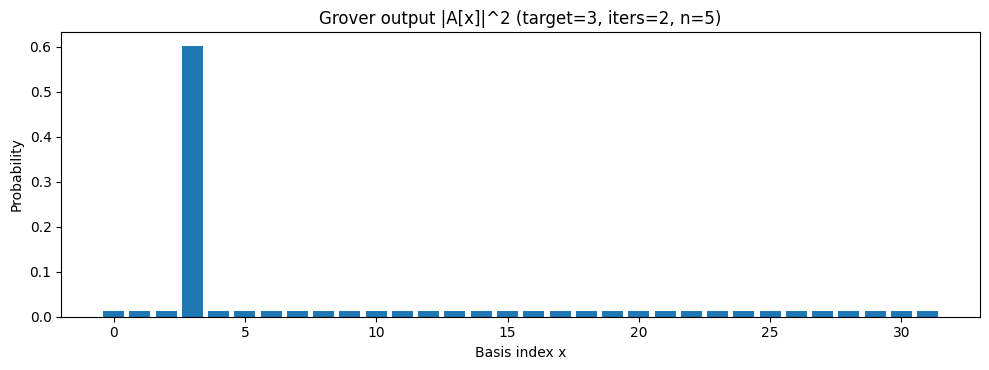


--- Quantum dataflow diagram ---


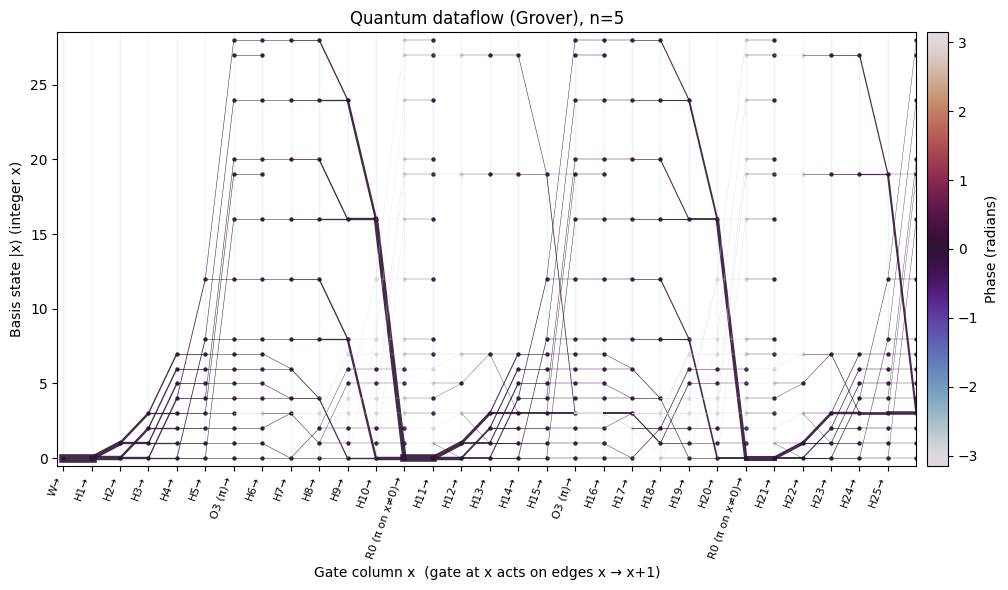

In [47]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Qiskit helpers (circuit + drawing + statevector)
# ============================================================

def require_qiskit():
    try:
        from qiskit import QuantumCircuit
        from qiskit.circuit import QuantumRegister, ClassicalRegister
        from qiskit.quantum_info import Statevector
        return QuantumCircuit, QuantumRegister, ClassicalRegister, Statevector
    except Exception as e:
        raise ImportError("Install Qiskit: pip install qiskit") from e


def labeled_gate_from_subcircuit(sub_qc, label: str):
    g = sub_qc.to_gate()
    g.label = label
    return g


def make_labeled_H(label: str):
    QuantumCircuit, _, _, _ = require_qiskit()
    sub = QuantumCircuit(1)
    sub.h(0)
    return labeled_gate_from_subcircuit(sub, label)


def plot_circuit(qc):
    """Plot circuit; fallback to text if mpl draw isn't available."""
    try:
        fig = qc.draw(output="mpl", fold=-1)
        plt.show()
        return fig
    except Exception:
        print(qc.draw(output="text", fold=200))
        return None


# ============================================================
# Oracle + Diffuser as diagonal “phase flip” boxes
# ============================================================

def diagonal_oracle_flip_state(num_qubits: int, target_state: int) -> np.ndarray:
    """
    Oracle phase flip: O_t |x> = -|x> if x==t else |x>.
    Implemented as diagonal entries (+1 except at target, where -1).
    """
    N = 1 << num_qubits
    t = int(target_state) % N
    diag = np.ones(N, dtype=complex)
    diag[t] = -1.0 + 0.0j  # 180° phase flip
    return diag


def diagonal_reflect_about_zero(num_qubits: int) -> np.ndarray:
    """
    Reflection about |0...0>:
      R0 = 2|0><0| - I
    Diagonal entries: +1 at 0, -1 elsewhere.
    """
    N = 1 << num_qubits
    diag = -np.ones(N, dtype=complex)
    diag[0] = 1.0 + 0.0j
    return diag


def build_diagonal_gate(diag: np.ndarray, label: str):
    """
    Build a labeled diagonal gate in Qiskit.
    """
    try:
        from qiskit.circuit.library import Diagonal  # type: ignore
    except Exception as e:
        raise ImportError("Need qiskit.circuit.library.Diagonal (part of Qiskit).") from e

    gate = Diagonal(diag).to_gate()
    gate.label = label
    return gate


# ============================================================
# Grover circuit (W -> H ladder -> Oracle flip |3> -> Diffuser)
# ============================================================

def build_grover_circuit(
    num_qubits: int,
    *,
    target_state: int = 3,
    iterations: int = 1,
    add_measurement_R: bool = True,
):
    QuantumCircuit, QuantumRegister, ClassicalRegister, _ = require_qiskit()

    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(num_qubits, "c") if add_measurement_R else None
    qc = QuantumCircuit(q, c) if c is not None else QuantumCircuit(q)

    # W marker
    try:
        qc.barrier(label="W")
    except TypeError:
        qc.barrier()

    # H ladder: H1..Hn
    H_i = 1
    for i in range(num_qubits):
        qc.append(make_labeled_H(f"H{H_i}"), [q[i]])
        H_i += 1

    N = 1 << num_qubits

    # Grover iterations: (Oracle -> Diffuser)^r
    for it in range(iterations):
        # Oracle: flip |target_state>
        oracle_diag = diagonal_oracle_flip_state(num_qubits, target_state)
        oracle_gate = build_diagonal_gate(oracle_diag, f"O{int(target_state)%N} (π)")
        qc.append(oracle_gate, list(q))

        # Diffuser: H⊗n -> (2|0><0|-I) -> H⊗n
        # First H ladder
        for i in range(num_qubits):
            qc.append(make_labeled_H(f"H{H_i}"), [q[i]])
            H_i += 1

        r0_diag = diagonal_reflect_about_zero(num_qubits)
        r0_gate = build_diagonal_gate(r0_diag, "R0 (π on x≠0)")
        qc.append(r0_gate, list(q))

        # Second H ladder
        for i in range(num_qubits):
            qc.append(make_labeled_H(f"H{H_i}"), [q[i]])
            H_i += 1

    # R marker + measurement
    if add_measurement_R and c is not None:
        try:
            qc.barrier(label="R")
        except TypeError:
            qc.barrier()
        qc.measure(q, c)

    return qc




@dataclass(frozen=True)
class Edge:
    src: int
    dst: int
    weight: float
    phase: float


@dataclass(frozen=True)
class Step:
    label: str
    kind: str  # 'W','H','DIAG'
    qargs: Tuple[int, ...] = ()
    diag: Optional[np.ndarray] = None


def _apply_h(state: np.ndarray, num_qubits: int, q: int, *, amp_epsilon: float = 1e-15):
    """
    Hadamard with edge weights based on destination probabilities |out|^2
    to avoid stray edges into destructively-cancelled destinations.
    """
    N = 1 << num_qubits
    inv_sqrt2 = 1.0 / math.sqrt(2.0)
    out = state.copy()
    edges = []
    bit = 1 << q

    for i in range(N):
        if i & bit:
            continue
        j = i | bit

        ai, aj = state[i], state[j]

        oi = (ai + aj) * inv_sqrt2
        oj = (ai - aj) * inv_sqrt2

        if abs(oi) < amp_epsilon:
            oi = 0.0 + 0.0j
        if abs(oj) < amp_epsilon:
            oj = 0.0 + 0.0j

        out[i] = oi
        out[j] = oj

        p_oi = float(abs(oi) ** 2)
        p_oj = float(abs(oj) ** 2)

        c_i = float(abs(ai) ** 2) * 0.5
        c_j = float(abs(aj) ** 2) * 0.5
        total = c_i + c_j
        if total <= 0.0:
            continue

        if p_oi > 0.0:
            edges.append((i, i, p_oi * (c_i / total)))
            edges.append((j, i, p_oi * (c_j / total)))
        if p_oj > 0.0:
            edges.append((i, j, p_oj * (c_i / total)))
            edges.append((j, j, p_oj * (c_j / total)))

    return out, edges


def _apply_diag(state: np.ndarray, diag: np.ndarray):
    out = state * diag
    edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(state.size)]
    return out, edges


def build_grover_steps(
    num_qubits: int,
    *,
    target_state: int = 3,
    iterations: int = 1,
) -> List[Step]:
    """
    Steps list (NO marker columns):
      W,
      H1..Hn,
      repeat iterations:
        Oracle O_target (diag)
        H ladder
        R0 (diag)
        H ladder
    """
    steps: List[Step] = [Step(label="W", kind="W")]

    # H ladder H1..Hn
    H_i = 1
    for q in range(num_qubits):
        steps.append(Step(label=f"H{H_i}", kind="H", qargs=(q,)))
        H_i += 1

    N = 1 << num_qubits

    for _ in range(iterations):
        # Oracle diag
        oracle = diagonal_oracle_flip_state(num_qubits, target_state)
        steps.append(Step(label=f"O{int(target_state)%N} (π)", kind="DIAG", diag=oracle))

        # Diffuser: H.., R0, H..
        for q in range(num_qubits):
            steps.append(Step(label=f"H{H_i}", kind="H", qargs=(q,)))
            H_i += 1

        r0 = diagonal_reflect_about_zero(num_qubits)
        steps.append(Step(label="R0 (π on x≠0)", kind="DIAG", diag=r0))

        for q in range(num_qubits):
            steps.append(Step(label=f"H{H_i}", kind="H", qargs=(q,)))
            H_i += 1

    return steps


def simulate_dataflow(num_qubits: int, steps: Sequence[Step], *, amp_epsilon: float = 1e-15):
    """
    Returns:
      states[x] for x=0..len(steps)  (x=0 is the initial state column)
      edges_by_step[i] for applying steps[i] from x=i -> x=i+1
    """
    N = 1 << num_qubits
    state = np.zeros(N, dtype=complex)
    state[0] = 1.0 + 0.0j

    states: List[np.ndarray] = [state.copy()]
    edges_by_step: List[List[Edge]] = []

    for s in steps:
        if s.kind == "H":
            new_state, raw_edges = _apply_h(state, num_qubits, s.qargs[0], amp_epsilon=amp_epsilon)
        elif s.kind == "DIAG":
            assert s.diag is not None
            new_state, raw_edges = _apply_diag(state, s.diag)
        elif s.kind == "W":
            new_state = state.copy()
            raw_edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(N)]
        else:
            raise ValueError(f"Unsupported step kind: {s.kind}")

        # snap tiny amplitudes to 0
        new_state = new_state.copy()
        new_state[np.abs(new_state) < amp_epsilon] = 0.0 + 0.0j

        # stable phases only for non-tiny amplitudes
        dest_phase = np.zeros(N, dtype=float)
        mask = np.abs(new_state) >= amp_epsilon
        dest_phase[mask] = np.angle(new_state[mask])

        edges_by_step.append([
            Edge(src=i, dst=j, weight=w, phase=float(dest_phase[j]))
            for (i, j, w) in raw_edges
        ])

        state = new_state
        states.append(state.copy())

    return states, edges_by_step


def plot_quantum_dataflow(
    num_qubits: int,
    steps: Sequence[Step],
    states: Sequence[np.ndarray],
    edges_by_step: Sequence[Sequence[Edge]],
    *,
    max_states_to_plot: int = 64,
    prob_threshold: float = 1e-12,
    edge_threshold: float = 1e-12,
    show_step_columns: bool = True,
):
    """
    Gate-at-column convention:
      - Gate/step i located at integer x=i (labeled at x=i)
      - Its effect is edges drawn from x=i -> x=i+1
      - Final state column x=len(steps) is unlabeled
    """
    N = 1 << num_qubits
    ncols = len(steps) + 1

    # choose basis states to show (max prob over time)
    if max_states_to_plot >= N:
        keep = np.arange(N, dtype=int)
    else:
        all_probs = np.stack([np.abs(s) ** 2 for s in states], axis=0)
        importance = np.max(all_probs, axis=0)
        keep = np.argsort(importance)[::-1][:max_states_to_plot]
        keep = np.sort(keep)
    keep_set = set(int(x) for x in keep)

    # linewidth normalization
    max_w = 0.0
    for edges in edges_by_step:
        for e in edges:
            if e.src in keep_set and e.dst in keep_set and e.weight > edge_threshold:
                max_w = max(max_w, e.weight)
    if max_w == 0.0:
        max_w = 1.0

    fig, ax = plt.subplots(figsize=(max(11.0, 0.35 * ncols), max(6.0, 0.18 * len(keep))))
    cmap = plt.get_cmap("twilight")

    # faint vertical lines at step columns
    if show_step_columns:
        for x in range(len(steps)):
            ax.axvline(x, linewidth=1.0, alpha=0.08)

    # edges: step i from x=i -> x=i+1
    for i, edges in enumerate(edges_by_step):
        for e in edges:
            if e.src not in keep_set or e.dst not in keep_set:
                continue
            if e.weight <= edge_threshold:
                continue
            phase_norm = (e.phase + math.pi) / (2.0 * math.pi)
            lw = 0.2 + 6.0 * (e.weight / max_w)
            ax.plot([i, i + 1], [e.src, e.dst], linewidth=lw, color=cmap(phase_norm), alpha=0.9)

    # nodes
    for x in range(len(states)):
        probs = np.abs(states[x]) ** 2
        ph = np.angle(states[x])
        for b in keep:
            if probs[b] <= prob_threshold:
                continue
            ax.scatter([x], [b], s=10,
                       color=cmap((ph[b] + math.pi) / (2.0 * math.pi)),
                       alpha=0.95, linewidths=0)

    ax.set_title(f"Quantum dataflow (Grover), n={num_qubits}")
    ax.set_xlabel("Gate column x  (gate at x acts on edges x → x+1)")
    ax.set_ylabel("Basis state |x⟩ (integer x)")
    ax.set_xlim(-0.2, ncols - 1)
    ax.set_ylim(min(keep) - 0.5, max(keep) + 0.5)

    # label only gate columns; final column unlabeled
    ax.set_xticks(range(0, len(steps)))
    ax.set_xticklabels([f"{s.label}→" for s in steps], rotation=70, ha="right", fontsize=8)

    # phase colorbar
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=-math.pi, vmax=math.pi)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Phase (radians)")

    fig.tight_layout()
    plt.show()
    return fig, ax


# ============================================================
# Output spectrum plot + peak listing
# ============================================================

def plot_output_distribution(state: np.ndarray, *, title: str):
    probs = np.abs(state) ** 2
    plt.figure(figsize=(10, 3.8))
    plt.bar(np.arange(len(probs)), probs)
    plt.xlabel("Basis index x")
    plt.ylabel("Probability")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def print_top_bins(state: np.ndarray, num_qubits: int, top_k: int = 16):
    probs = np.abs(state) ** 2
    order = np.argsort(probs)[::-1]
    print("\nTop outcomes:")
    for idx in order[:top_k]:
        if probs[idx] < 1e-12:
            break
        print(f"  x={idx:4d}  bin={format(idx, f'0{num_qubits}b')}  prob={probs[idx]:.6f}")


# ============================================================
# Main runner
# ============================================================

def run_grover(
    num_qubits: int = 2,
    target_state: int = 3,
    iterations: int = 1,
    *,
    max_states_to_plot: int = 64,
    amp_epsilon: float = 1e-15,
):
    QuantumCircuit, _, _, Statevector = require_qiskit()

    qc = build_grover_circuit(
        num_qubits,
        target_state=target_state,
        iterations=iterations,
        add_measurement_R=True,
    )

    print("\n--- Circuit diagram ---")
    plot_circuit(qc)

    # Statevector simulation (remove final measurements)
    qc_nom = qc.remove_final_measurements(inplace=False)
    sv = Statevector.from_instruction(qc_nom)
    final = np.asarray(sv.data, dtype=complex)

    print("\n--- Final distribution ---")
    print_top_bins(final, num_qubits=num_qubits, top_k=min(16, 1 << num_qubits))
    plot_output_distribution(final, title=f"Grover output |A[x]|^2 (target={target_state}, iters={iterations}, n={num_qubits})")

    print("\n--- Quantum dataflow diagram ---")
    steps = build_grover_steps(num_qubits, target_state=target_state, iterations=iterations)
    states, edges = simulate_dataflow(num_qubits, steps, amp_epsilon=amp_epsilon)
    plot_quantum_dataflow(num_qubits, steps, states, edges, max_states_to_plot=max_states_to_plot)


if __name__ == "__main__":
    # With n=2 (N=4) and target=3,
    run_grover(num_qubits=5, target_state=3, iterations=2, max_states_to_plot=16)

    # Try a larger
    # run_grover(num_qubits=4, target_state=3, iterations=1, max_states_to_plot=64)


# Shor's algorithms - simplified - N= 15


--- Circuit ---
        W ┌───┐                         C·U^1        ┌───┐                                                                            R ┌─┐         
  c_0: ─░─┤ H ├───────────────────────────■────────X─┤ H ├─■──────────────■───────────────────■───────────────────────────────────────░─┤M├─────────
        ░ ├───┤                 C·U^2     │        │ └───┘ │P(-π/2) ┌───┐ │                   │                                       ░ └╥┘┌─┐      
  c_1: ─░─┤ H ├───────────────────■───────┼─────X──┼───────■────────┤ H ├─┼─────────■─────────┼──────────────■────────────────────────░──╫─┤M├──────
        ░ ├───┤         C·U^4     │       │     │  │                └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │                        ░  ║ └╥┘┌─┐   
  c_2: ─░─┤ H ├───────────■───────┼───────┼─────X──┼──────────────────────■─────────■─────────┼────────┤ H ├─┼─────────■──────────────░──╫──╫─┤M├───
        ░ ├───┤ C·U^8     │       │       │        │                                     

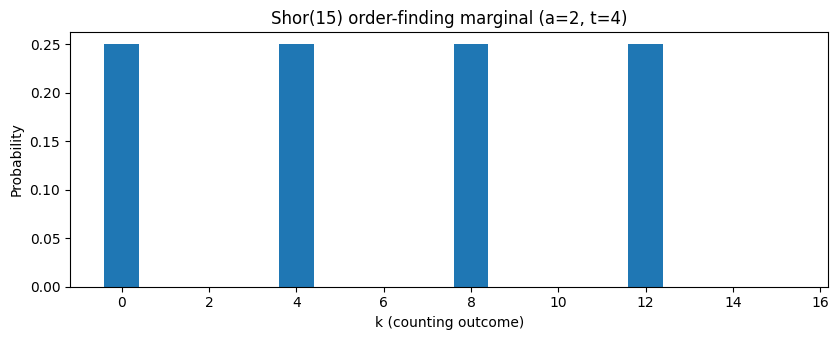


Chosen peak k=4, phase≈1/4 (≈0.2500), inferred r=4
Factors: 3 and 5

--- Quantum dataflow diagram ---


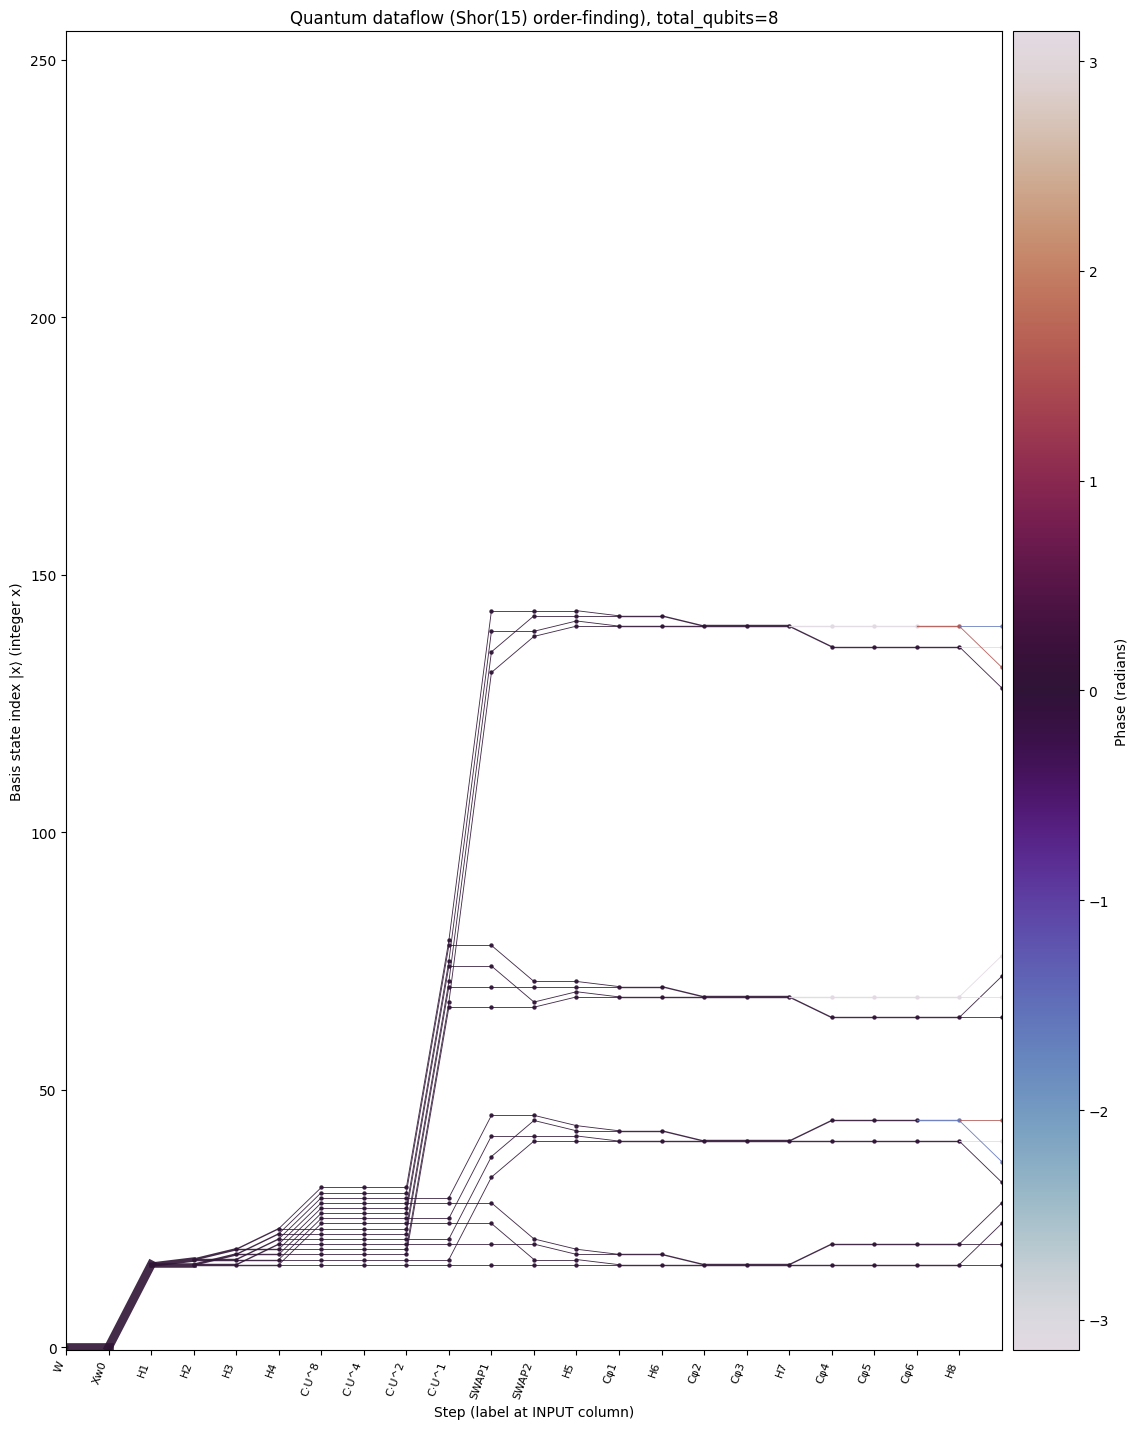

In [44]:
from __future__ import annotations

import math
from dataclasses import dataclass
from fractions import Fraction
from typing import List, Sequence, Tuple, Optional, Dict, Any

import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Qiskit helpers (circuit + drawing + statevector)
# ============================================================

def require_qiskit():
    try:
        from qiskit import QuantumCircuit  # type: ignore
        from qiskit.circuit import QuantumRegister, ClassicalRegister  # type: ignore
        from qiskit.quantum_info import Statevector  # type: ignore
        return QuantumCircuit, QuantumRegister, ClassicalRegister, Statevector
    except Exception as e:
        raise ImportError("Install Qiskit: pip install qiskit") from e


def plot_circuit(qc):
    try:
        fig = qc.draw(output="mpl", fold=-1)
        plt.show()
        return fig
    except Exception:
        print(qc.draw(output="text", fold=200))
        return None


# ============================================================
# Exact modular multiplication as a permutation on 4 work qubits
# U_{a^e}: |y> -> |(a^e * y) mod 15>, with |15> fixed (bijection on 16 states)
# ============================================================

def perm_mul_mod_15(a: int, e: int) -> List[int]:
    N = 15
    ae = pow(a, e, N)
    perm = list(range(16))
    for y in range(15):
        perm[y] = (ae * y) % N
    perm[15] = 15
    return perm


def perm_to_unitary(perm: Sequence[int]) -> np.ndarray:
    dim = len(perm)
    U = np.zeros((dim, dim), dtype=complex)
    for y, py in enumerate(perm):
        U[py, y] = 1.0
    return U


def make_controlled_mul_gate(a: int, e: int, label: str):
    # build 16x16 permutation matrix and control it -> 32x32 on (control + 4 work)
    try:
        from qiskit.circuit.library import UnitaryGate  # type: ignore
    except Exception:
        from qiskit.extensions import UnitaryGate  # type: ignore

    perm = perm_mul_mod_15(a, e)
    U = perm_to_unitary(perm)
    base = UnitaryGate(U, label=label)
    cgate = base.control(1)
    cgate.label = f"C·{label}"
    return cgate


# ============================================================
# IQFT on a list of qubits given in MSB->LSB order (includes swaps)
# ============================================================

def iqft_msb_first(qc, q_msb: Sequence):
    n = len(q_msb)

    # swaps
    for i in range(n // 2):
        qc.swap(q_msb[i], q_msb[n - 1 - i])

    # inverse QFT core
    for j in range(n - 1, -1, -1):
        for k in range(n - 1, j, -1):
            angle = -math.pi / (2 ** (k - j))
            qc.cp(angle, q_msb[k], q_msb[j])
        qc.h(q_msb[j])


# ============================================================
# marginal: MSB-first integer k over a given qubit list
# (uses actual global positions in qc.qubits)
# ============================================================

def marginal_probs_msb_first(state: np.ndarray, all_qubits: Sequence, qubits_msb: Sequence) -> np.ndarray:
    probs_full = np.abs(state) ** 2
    t = len(qubits_msb)
    out = np.zeros(1 << t, dtype=float)

    positions = [all_qubits.index(q) for q in qubits_msb]  # global bit positions

    for idx, p in enumerate(probs_full):
        k = 0
        for i, pos in enumerate(positions):
            bit = (idx >> pos) & 1
            k |= (bit << (t - 1 - i))
        out[k] += float(p)

    return out


# ============================================================
# Classical post-processing (factor extraction)
# ============================================================

def gcd(a: int, b: int) -> int:
    while b:
        a, b = b, a % b
    return abs(a)


def try_extract_factors_from_probs(
    probs: np.ndarray,
    *,
    t: int,
    a: int,
    N: int,
    max_den: int,
    top_try: int = 12,
):
    order = np.argsort(probs)[::-1]
    tried = 0

    for k in order:
        if probs[k] < 1e-12:
            break
        if k == 0:
            continue

        frac = Fraction(int(k), 1 << t).limit_denominator(max_den)
        r = frac.denominator
        tried += 1

        if r % 2 == 1:
            if tried >= top_try:
                break
            continue
        if pow(a, r, N) != 1:
            if tried >= top_try:
                break
            continue

        ar2 = pow(a, r // 2, N)
        p = gcd(ar2 - 1, N)
        q = gcd(ar2 + 1, N)

        if 1 < p < N and 1 < q < N:
            return int(k), frac, int(r), int(p), int(q)

        if tried >= top_try:
            break

    return None


# ============================================================
# Build Shor(15) order-finding circuit (a=2, t=4, work=4)
# ============================================================

def build_shor15_orderfinding(a: int = 2, t: int = 4):
    QuantumCircuit, QuantumRegister, ClassicalRegister, _ = require_qiskit()

    c = QuantumRegister(t, "c")      # counting
    w = QuantumRegister(4, "w")      # work (4 qubits for 0..15)
    out = ClassicalRegister(t, "out")
    qc = QuantumCircuit(c, w, out)

    # W marker
    try:
        qc.barrier(label="W")
    except TypeError:
        qc.barrier()

    # init work to |1>
    qc.x(w[0])

    # H ladder on counting
    for i in range(t):
        qc.h(c[i])

    # MSB->LSB list for QPE
    c_msb = [c[t - 1 - i] for i in range(t)]  # c[t-1],...,c[0]

    # Controlled U^{2^j}, MSB controls largest exponent
    for j, qb in enumerate(c_msb):
        exp = 1 << (t - 1 - j)  # 8,4,2,1 for t=4
        gate = make_controlled_mul_gate(a=a, e=exp, label=f"U^{exp}")
        qc.append(gate, [qb] + list(w))

    # IQFT on counting (MSB->LSB)
    iqft_msb_first(qc, c_msb)

    # R marker + measurement
    try:
        qc.barrier(label="R")
    except TypeError:
        qc.barrier()
    qc.measure(c, out)

    return qc, c_msb


# ============================================================
# Quantum dataflow diagram (labels on INPUT columns, no shift)
# Includes a controlled-permutation step for modular multiplication.
# ============================================================

@dataclass(frozen=True)
class Edge:
    src: int
    dst: int
    weight: float
    phase: float


@dataclass(frozen=True)
class Step:
    label: str
    kind: str  # 'W','X','H','CP','SWAP','CPERM'
    qargs: Tuple[int, ...] = ()
    angle: float = 0.0
    extra: Optional[Dict[str, Any]] = None


def _apply_x(state: np.ndarray, q: int):
    N = state.size
    out = np.zeros_like(state)
    edges = []
    bit = 1 << q
    for i in range(N):
        j = i ^ bit
        out[j] = state[i]
        edges.append((i, j, float(abs(state[i]) ** 2)))
    return out, edges


def _apply_h(state: np.ndarray, num_qubits: int, q: int, *, amp_epsilon: float = 1e-15):
    """
    Hadamard with edges weighted by destination probabilities |out|^2
    to suppress stray edges into destructively canceled destinations.
    """
    N = 1 << num_qubits
    inv_sqrt2 = 1.0 / math.sqrt(2.0)
    out = state.copy()
    edges = []
    bit = 1 << q

    for i in range(N):
        if i & bit:
            continue
        j = i | bit

        ai, aj = state[i], state[j]

        oi = (ai + aj) * inv_sqrt2
        oj = (ai - aj) * inv_sqrt2

        if abs(oi) < amp_epsilon:
            oi = 0.0 + 0.0j
        if abs(oj) < amp_epsilon:
            oj = 0.0 + 0.0j

        out[i] = oi
        out[j] = oj

        p_oi = float(abs(oi) ** 2)
        p_oj = float(abs(oj) ** 2)

        c_i = float(abs(ai) ** 2) * 0.5
        c_j = float(abs(aj) ** 2) * 0.5
        total = c_i + c_j
        if total <= 0.0:
            continue

        if p_oi > 0.0:
            edges.append((i, i, p_oi * (c_i / total)))
            edges.append((j, i, p_oi * (c_j / total)))
        if p_oj > 0.0:
            edges.append((i, j, p_oj * (c_i / total)))
            edges.append((j, j, p_oj * (c_j / total)))

    return out, edges


def _apply_cp(state: np.ndarray, num_qubits: int, control: int, target: int, angle: float):
    N = 1 << num_qubits
    out = state.copy()
    edges = []
    cbit, tbit = 1 << control, 1 << target
    phase = np.exp(1j * angle)

    for i in range(N):
        edges.append((i, i, float(abs(state[i]) ** 2)))
        if (i & cbit) and (i & tbit):
            out[i] *= phase

    return out, edges


def _swap_bits(i: int, q1: int, q2: int) -> int:
    if q1 == q2:
        return i
    b1 = (i >> q1) & 1
    b2 = (i >> q2) & 1
    if b1 == b2:
        return i
    return i ^ ((1 << q1) | (1 << q2))


def _apply_swap(state: np.ndarray, num_qubits: int, q1: int, q2: int):
    N = 1 << num_qubits
    out = np.zeros_like(state)
    edges = []
    for i in range(N):
        j = _swap_bits(i, q1, q2)
        out[j] = state[i]
        edges.append((i, j, float(abs(state[i]) ** 2)))
    return out, edges


def _apply_controlled_perm(
    state: np.ndarray,
    num_qubits: int,
    control_q: int,
    target_qs: Sequence[int],
    perm: Sequence[int],
):
    """
    Controlled permutation on the target subregister (treated little-endian in target_qs order).
    If control bit == 1: y -> perm[y]; else identity.
    Pure “move” edges (no branching).
    """
    N = 1 << num_qubits
    out = np.zeros_like(state)
    edges = []

    tqs = list(target_qs)
    tlen = len(tqs)

    for i in range(N):
        amp = state[i]
        if amp == 0:
            continue

        cbit = (i >> control_q) & 1
        if cbit == 0:
            j = i
        else:
            # extract y from target bits (little-endian across tqs)
            y = 0
            for b in range(tlen):
                y |= (((i >> tqs[b]) & 1) << b)
            y2 = perm[y]

            # write back y2 into target bits, keep others same
            j = i
            for b in range(tlen):
                bit_old = (j >> tqs[b]) & 1
                bit_new = (y2 >> b) & 1
                if bit_old != bit_new:
                    j ^= (1 << tqs[b])

        out[j] += amp
        edges.append((i, j, float(abs(amp) ** 2)))

    return out, edges


def build_dataflow_steps_shor15(a: int = 2, t: int = 4) -> Tuple[List[Step], int]:
    """
    Steps match the circuit order:
      W, X(w0), H on counting (c0..c_{t-1}), then controlled-U^{8,4,2,1} (MSB->LSB),
      then IQFT: swaps + CP ladder + H, then (optional R marker could be added)
    Qubit indices assume qc.qubits order: [c0,c1,c2,c3,w0,w1,w2,w3] => total=8.
    """
    n_total = t + 4
    c_idxs = list(range(t))              # 0..3
    w_idxs = list(range(t, t + 4))       # 4..7

    steps: List[Step] = [Step("W", "W")]

    # X on work LSB to prepare |1>
    steps.append(Step("Xw0", "X", qargs=(w_idxs[0],)))

    # H ladder on counting in circuit order c0,c1,c2,c3
    for i, q in enumerate(c_idxs):
        steps.append(Step(f"H{i+1}", "H", qargs=(q,)))

    # Controlled U^{8,4,2,1} with MSB->LSB controls: c3,c2,c1,c0
    c_msb = [c_idxs[t - 1 - i] for i in range(t)]  # [3,2,1,0]
    for j, ctrl in enumerate(c_msb):
        exp = 1 << (t - 1 - j)  # 8,4,2,1
        perm = perm_mul_mod_15(a, exp)
        steps.append(Step(f"C·U^{exp}", "CPERM", qargs=(ctrl, *w_idxs), extra={"perm": perm}))

    # IQFT on counting, MSB->LSB list is [c3,c2,c1,c0]
    # swaps: (c3<->c0), (c2<->c1)
    steps.append(Step("SWAP1", "SWAP", qargs=(c_msb[0], c_msb[-1])))
    steps.append(Step("SWAP2", "SWAP", qargs=(c_msb[1], c_msb[-2])))

    # inverse QFT core (same as iqft_msb_first)
    cp_idx = 1
    h_idx = t + 1
    n = len(c_msb)

    for jj in range(n - 1, -1, -1):
        for kk in range(n - 1, jj, -1):
            angle = -math.pi / (2 ** (kk - jj))
            steps.append(Step(f"Cφ{cp_idx}", "CP", qargs=(c_msb[kk], c_msb[jj]), angle=angle))
            cp_idx += 1
        steps.append(Step(f"H{h_idx}", "H", qargs=(c_msb[jj],)))
        h_idx += 1

    return steps, n_total


def simulate_dataflow(num_qubits: int, steps: Sequence[Step], *, amp_epsilon: float = 1e-15):
    """
    Alignment (labels on INPUT columns):
      - step i label at x=i
      - step i edges drawn from x=i -> x=i+1
      - final column x=len(steps) is unlabeled
    """
    N = 1 << num_qubits
    state = np.zeros(N, dtype=complex)
    state[0] = 1.0 + 0j

    states: List[np.ndarray] = [state.copy()]
    edges_by_step: List[List[Edge]] = []

    for s in steps:
        if s.kind == "W":
            new_state = state.copy()
            raw_edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(N)]

        elif s.kind == "X":
            q = s.qargs[0]
            new_state, raw_edges = _apply_x(state, q)

        elif s.kind == "H":
            q = s.qargs[0]
            new_state, raw_edges = _apply_h(state, num_qubits, q, amp_epsilon=amp_epsilon)

        elif s.kind == "CP":
            c, t = s.qargs
            new_state, raw_edges = _apply_cp(state, num_qubits, c, t, s.angle)

        elif s.kind == "SWAP":
            q1, q2 = s.qargs
            new_state, raw_edges = _apply_swap(state, num_qubits, q1, q2)

        elif s.kind == "CPERM":
            ctrl = s.qargs[0]
            targets = s.qargs[1:]
            perm = s.extra["perm"] if s.extra is not None else None
            assert perm is not None
            new_state, raw_edges = _apply_controlled_perm(state, num_qubits, ctrl, targets, perm)

        else:
            raise ValueError(f"Unsupported step kind: {s.kind}")

        # snap tiny amplitudes to 0
        new_state = new_state.copy()
        new_state[np.abs(new_state) < amp_epsilon] = 0.0 + 0.0j

        # stable phases only where amplitude is not tiny
        dest_phase = np.zeros(N, dtype=float)
        mask = np.abs(new_state) >= amp_epsilon
        dest_phase[mask] = np.angle(new_state[mask])

        edges_by_step.append([Edge(src=i, dst=j, weight=w, phase=float(dest_phase[j])) for (i, j, w) in raw_edges])

        state = new_state
        states.append(state.copy())

    return states, edges_by_step


def plot_quantum_dataflow(
    num_qubits: int,
    steps: Sequence[Step],
    states: Sequence[np.ndarray],
    edges_by_step: Sequence[Sequence[Edge]],
    *,
    max_states_to_plot: int = 64,
    prob_threshold: float = 1e-12,
    edge_threshold: float = 1e-12,
):
    """
    Labels on INPUT columns (no shift):
      x=0..len(steps)-1 labeled by steps
      x=len(steps) unlabeled final column
    """
    N = 1 << num_qubits
    ncols = len(steps) + 1

    # choose basis states to show by max probability over time
    if max_states_to_plot >= N:
        keep = np.arange(N, dtype=int)
    else:
        all_probs = np.stack([np.abs(s) ** 2 for s in states], axis=0)
        importance = np.max(all_probs, axis=0)
        keep = np.argsort(importance)[::-1][:max_states_to_plot]
        keep = np.sort(keep)
    keep_set = set(int(x) for x in keep)

    # linewidth normalization
    max_w = 0.0
    for edges in edges_by_step:
        for e in edges:
            if e.src in keep_set and e.dst in keep_set and e.weight > edge_threshold:
                max_w = max(max_w, e.weight)
    if max_w == 0.0:
        max_w = 1.0

    fig, ax = plt.subplots(figsize=(max(12.0, 0.38 * ncols), max(6.0, 0.18 * len(keep))))
    cmap = plt.get_cmap("twilight")

    # edges: step i from x=i -> x=i+1
    for i, edges in enumerate(edges_by_step):
        for e in edges:
            if e.src not in keep_set or e.dst not in keep_set:
                continue
            if e.weight <= edge_threshold:
                continue
            phase_norm = (e.phase + math.pi) / (2.0 * math.pi)
            lw = 0.25 + 6.0 * (e.weight / max_w)
            ax.plot([i, i + 1], [e.src, e.dst], linewidth=lw, color=cmap(phase_norm), alpha=0.9)

    # nodes
    for x in range(len(states)):
        probs = np.abs(states[x]) ** 2
        ph = np.angle(states[x])
        for b in keep:
            if probs[b] <= prob_threshold:
                continue
            ax.scatter([x], [b], s=10, color=cmap((ph[b] + math.pi) / (2.0 * math.pi)),
                       alpha=0.95, linewidths=0)

    ax.set_title(f"Quantum dataflow (Shor(15) order-finding), total_qubits={num_qubits}")
    ax.set_xlabel("Step (label at INPUT column)")
    ax.set_ylabel("Basis state index |x⟩ (integer x)")
    ax.set_xlim(0, ncols - 1)
    ax.set_ylim(min(keep) - 0.5, max(keep) + 0.5)

    ax.set_xticks(range(0, len(steps)))
    ax.set_xticklabels([s.label for s in steps], rotation=70, ha="right", fontsize=8)

    # phase colorbar
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=-math.pi, vmax=math.pi)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Phase (radians)")

    fig.tight_layout()
    plt.show()
    return fig, ax


# ============================================================
# Main runner (circuit + marginal + dataflow)
# ============================================================

def run_shor15_with_dataflow(
    *,
    a: int = 2,
    t: int = 4,
    amp_epsilon: float = 1e-15,
    max_states_to_plot: int = 80,
):
    QuantumCircuit, _, _, Statevector = require_qiskit()

    qc, c_msb = build_shor15_orderfinding(a=a, t=t)

    print("\n--- Circuit ---")
    plot_circuit(qc)

    # statevector
    qc_nom = qc.remove_final_measurements(inplace=False)
    sv = Statevector.from_instruction(qc_nom)
    state = np.asarray(sv.data, dtype=complex)

    # counting marginal (MSB-first)
    probs = marginal_probs_msb_first(state, qc.qubits, c_msb)

    print("\n--- Counting register marginal (MSB-first k) ---")
    order = np.argsort(probs)[::-1]
    for k in order[:16]:
        if probs[k] < 1e-12:
            break
        print(f"  k={k:2d}  bin={format(k, f'0{t}b')}  prob={probs[k]:.6f}")

    plt.figure(figsize=(8.5, 3.5))
    plt.bar(np.arange(len(probs)), probs)
    plt.xlabel("k (counting outcome)")
    plt.ylabel("Probability")
    plt.title(f"Shor(15) order-finding marginal (a={a}, t={t})")
    plt.tight_layout()
    plt.show()

    res = try_extract_factors_from_probs(probs, t=t, a=a, N=15, max_den=15, top_try=12)
    if res is not None:
        k, frac, r, p, q = res
        print(f"\nChosen peak k={k}, phase≈{frac} (≈{float(frac):.4f}), inferred r={r}")
        print(f"Factors: {p} and {q}")
    else:
        print("\nCould not extract nontrivial factors from top peaks (unexpected for this clean demo).")

    # Dataflow
    print("\n--- Quantum dataflow diagram ---")
    steps, n_total = build_dataflow_steps_shor15(a=a, t=t)
    states, edges = simulate_dataflow(n_total, steps, amp_epsilon=amp_epsilon)
    plot_quantum_dataflow(
        n_total, steps, states, edges,
        max_states_to_plot=max_states_to_plot,
        prob_threshold=1e-12,
        edge_threshold=1e-12,
    )


if __name__ == "__main__":
    run_shor15_with_dataflow(a=2, t=4, amp_epsilon=1e-15, max_states_to_plot=80)


Precision register only dataflow


--- Final precision marginal (MSB-first k) ---
  k=12  bin=1100  prob=0.250000
  k= 8  bin=1000  prob=0.250000
  k= 0  bin=0000  prob=0.250000
  k= 4  bin=0100  prob=0.250000


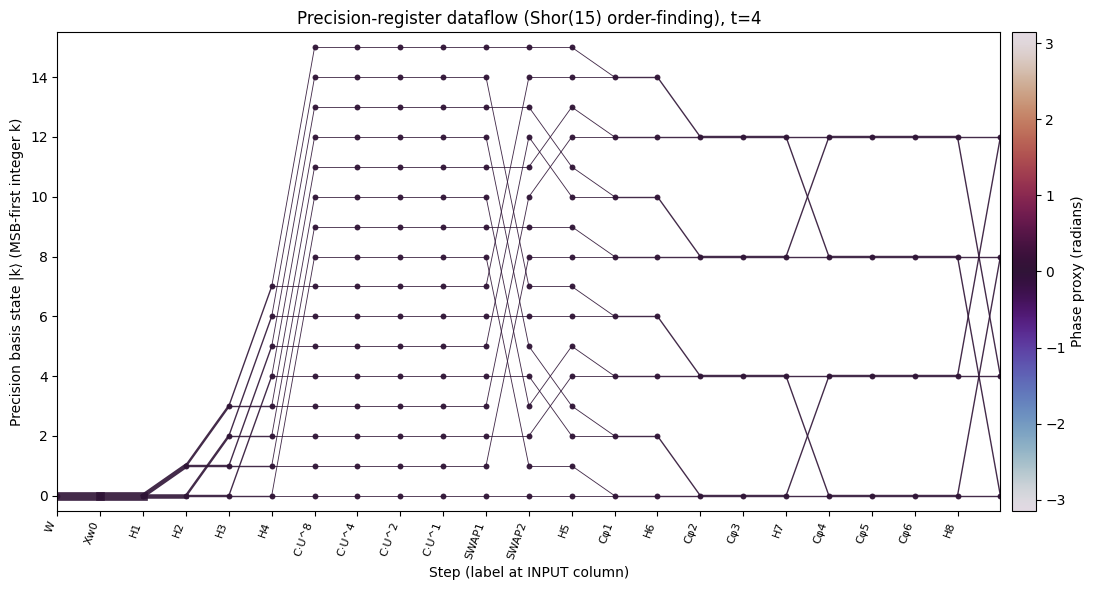

In [45]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Shor(15) modular multiply as a permutation on 4 work qubits
# ============================================================

def perm_mul_mod_15(a: int, e: int) -> List[int]:
    """
    Permutation on {0..15}:
      y -> (a^e * y) mod 15 for y=0..14, and 15->15 (to keep a bijection on 16 states).
    """
    N = 15
    ae = pow(a, e, N)
    perm = list(range(16))
    for y in range(15):
        perm[y] = (ae * y) % N
    perm[15] = 15
    return perm


# ============================================================
# Dataflow primitives (full system)
# Convention:
#   - labels on INPUT columns x=0..len(steps)-1
#   - step i edges from x=i -> x=i+1
#   - final column unlabeled
# ============================================================

@dataclass(frozen=True)
class EdgeFull:
    src: int
    dst: int
    weight: float
    phase: float  # phase at destination amplitude (full basis); for color


@dataclass(frozen=True)
class Step:
    label: str
    kind: str  # 'W','X','H','CP','SWAP','CPERM'
    qargs: Tuple[int, ...] = ()
    angle: float = 0.0
    extra: Optional[Dict[str, Any]] = None


def _apply_x(state: np.ndarray, q: int):
    N = state.size
    out = np.zeros_like(state)
    edges = []
    bit = 1 << q
    for i in range(N):
        j = i ^ bit
        out[j] = state[i]
        edges.append((i, j, float(abs(state[i]) ** 2)))
    return out, edges


def _apply_h(state: np.ndarray, num_qubits: int, q: int, *, amp_epsilon: float = 1e-15):
    """
    Hadamard with edges weighted by destination probabilities |out|^2
    (prevents stray tiny edges when destructive interference cancels amplitudes).
    """
    N = 1 << num_qubits
    inv_sqrt2 = 1.0 / math.sqrt(2.0)
    out = state.copy()
    edges = []
    bit = 1 << q

    for i in range(N):
        if i & bit:
            continue
        j = i | bit

        ai, aj = state[i], state[j]

        oi = (ai + aj) * inv_sqrt2
        oj = (ai - aj) * inv_sqrt2

        if abs(oi) < amp_epsilon:
            oi = 0.0 + 0.0j
        if abs(oj) < amp_epsilon:
            oj = 0.0 + 0.0j

        out[i] = oi
        out[j] = oj

        p_oi = float(abs(oi) ** 2)
        p_oj = float(abs(oj) ** 2)

        c_i = float(abs(ai) ** 2) * 0.5
        c_j = float(abs(aj) ** 2) * 0.5
        total = c_i + c_j
        if total <= 0.0:
            continue

        if p_oi > 0.0:
            edges.append((i, i, p_oi * (c_i / total)))
            edges.append((j, i, p_oi * (c_j / total)))
        if p_oj > 0.0:
            edges.append((i, j, p_oj * (c_i / total)))
            edges.append((j, j, p_oj * (c_j / total)))

    return out, edges


def _apply_cp(state: np.ndarray, num_qubits: int, control: int, target: int, angle: float):
    N = 1 << num_qubits
    out = state.copy()
    edges = []
    cbit, tbit = 1 << control, 1 << target
    phase = np.exp(1j * angle)

    for i in range(N):
        edges.append((i, i, float(abs(state[i]) ** 2)))
        if (i & cbit) and (i & tbit):
            out[i] *= phase

    return out, edges


def _swap_bits(i: int, q1: int, q2: int) -> int:
    if q1 == q2:
        return i
    b1 = (i >> q1) & 1
    b2 = (i >> q2) & 1
    if b1 == b2:
        return i
    return i ^ ((1 << q1) | (1 << q2))


def _apply_swap(state: np.ndarray, num_qubits: int, q1: int, q2: int):
    N = 1 << num_qubits
    out = np.zeros_like(state)
    edges = []
    for i in range(N):
        j = _swap_bits(i, q1, q2)
        out[j] = state[i]
        edges.append((i, j, float(abs(state[i]) ** 2)))
    return out, edges


def _apply_controlled_perm(
    state: np.ndarray,
    num_qubits: int,
    control_q: int,
    target_qs: Sequence[int],
    perm: Sequence[int],
):
    """
    Controlled permutation on target subregister (little-endian in target_qs order).
    Pure move edges (no branching).
    """
    N = 1 << num_qubits
    out = np.zeros_like(state)
    edges = []

    tqs = list(target_qs)
    tlen = len(tqs)

    for i in range(N):
        amp = state[i]
        if amp == 0:
            continue

        cbit = (i >> control_q) & 1
        if cbit == 0:
            j = i
        else:
            y = 0
            for b in range(tlen):
                y |= (((i >> tqs[b]) & 1) << b)
            y2 = perm[y]

            j = i
            for b in range(tlen):
                bit_old = (j >> tqs[b]) & 1
                bit_new = (y2 >> b) & 1
                if bit_old != bit_new:
                    j ^= (1 << tqs[b])

        out[j] += amp
        edges.append((i, j, float(abs(amp) ** 2)))

    return out, edges


def simulate_full_dataflow(num_qubits: int, steps: Sequence[Step], *, amp_epsilon: float = 1e-15):
    """
    Returns:
      full_states[x] for x=0..len(steps) (x=0 is initial)
      full_edges_by_step[i] edges for applying step i from x=i -> x=i+1
    """
    N = 1 << num_qubits
    state = np.zeros(N, dtype=complex)
    state[0] = 1.0 + 0j

    full_states: List[np.ndarray] = [state.copy()]
    full_edges_by_step: List[List[EdgeFull]] = []

    for s in steps:
        if s.kind == "W":
            new_state = state.copy()
            raw_edges = [(i, i, float(abs(state[i]) ** 2)) for i in range(N)]

        elif s.kind == "X":
            q = s.qargs[0]
            new_state, raw_edges = _apply_x(state, q)

        elif s.kind == "H":
            q = s.qargs[0]
            new_state, raw_edges = _apply_h(state, num_qubits, q, amp_epsilon=amp_epsilon)

        elif s.kind == "CP":
            c, t = s.qargs
            new_state, raw_edges = _apply_cp(state, num_qubits, c, t, s.angle)

        elif s.kind == "SWAP":
            q1, q2 = s.qargs
            new_state, raw_edges = _apply_swap(state, num_qubits, q1, q2)

        elif s.kind == "CPERM":
            ctrl = s.qargs[0]
            targets = s.qargs[1:]
            perm = (s.extra or {}).get("perm")
            assert perm is not None
            new_state, raw_edges = _apply_controlled_perm(state, num_qubits, ctrl, targets, perm)

        else:
            raise ValueError(f"Unsupported step kind: {s.kind}")

        # snap tiny amplitudes to 0
        new_state = new_state.copy()
        new_state[np.abs(new_state) < amp_epsilon] = 0.0 + 0.0j

        # phase at destination basis states (full)
        dest_phase = np.zeros(N, dtype=float)
        mask = np.abs(new_state) >= amp_epsilon
        dest_phase[mask] = np.angle(new_state[mask])

        full_edges_by_step.append([
            EdgeFull(src=i, dst=j, weight=w, phase=float(dest_phase[j]))
            for (i, j, w) in raw_edges
        ])

        state = new_state
        full_states.append(state.copy())

    return full_states, full_edges_by_step


# ============================================================
# Build Shor(15) order-finding steps (a=2, t=4) on 8 qubits
# Qubit layout (fixed):
#   precision: c0..c_{t-1}  -> indices 0..t-1
#   work:     w0..w3       -> indices t..t+3
#
# IMPORTANT: precision integer k is read MSB-first from [c_{t-1},...,c0]
# ============================================================

def build_shor15_steps(a: int = 2, t: int = 4) -> Tuple[List[Step], int, List[int]]:
    """
    Returns: (steps, n_total_qubits, counting_qubits_msb)
    """
    n_total = t + 4
    c = list(range(t))              # 0..t-1
    w = list(range(t, t + 4))       # t..t+3
    c_msb = list(range(t - 1, -1, -1))

    steps: List[Step] = [Step("W", "W")]

    # prepare work |1> (X on w0)
    steps.append(Step("Xw0", "X", qargs=(w[0],)))

    # H ladder on counting
    for i, q in enumerate(c):
        steps.append(Step(f"H{i+1}", "H", qargs=(q,)))

    # Controlled U^{8,4,2,1} with MSB->LSB controls: c_{t-1}..c0
    for j, ctrl in enumerate(c_msb):
        exp = 1 << (t - 1 - j)  # 8,4,2,1 for t=4
        perm = perm_mul_mod_15(a, exp)
        steps.append(Step(f"C·U^{exp}", "CPERM", qargs=(ctrl, *w), extra={"perm": perm}))

    # IQFT on counting MSB->LSB (includes swaps)
    # swaps: (c_{t-1} <-> c0), (c_{t-2} <-> c1), ...
    sidx = 1
    for i in range(t // 2):
        steps.append(Step(f"SWAP{sidx}", "SWAP", qargs=(c_msb[i], c_msb[-1 - i])))
        sidx += 1

    # inverse QFT core: CP ladder (negative angles) then H, from LSB end of the decomposed order
    cp_idx = 1
    h_idx = t + 1
    n = len(c_msb)
    for jj in range(n - 1, -1, -1):
        for kk in range(n - 1, jj, -1):
            angle = -math.pi / (2 ** (kk - jj))
            steps.append(Step(f"Cφ{cp_idx}", "CP", qargs=(c_msb[kk], c_msb[jj]), angle=angle))
            cp_idx += 1
        steps.append(Step(f"H{h_idx}", "H", qargs=(c_msb[jj],)))
        h_idx += 1

    return steps, n_total, c_msb


# ============================================================
# Precision-only marginalization of states + edges
# ============================================================

@dataclass(frozen=True)
class EdgePrec:
    src_k: int
    dst_k: int
    weight: float
    phase: float  # phase proxy at destination k (see notes)


def index_to_k_msb(idx: int, counting_qubits_msb: Sequence[int]) -> int:
    t = len(counting_qubits_msb)
    k = 0
    for i, q in enumerate(counting_qubits_msb):
        bit = (idx >> q) & 1
        k |= (bit << (t - 1 - i))
    return k


def precision_marginal_probs(full_state: np.ndarray, counting_qubits_msb: Sequence[int]) -> np.ndarray:
    t = len(counting_qubits_msb)
    probs = np.zeros(1 << t, dtype=float)
    full_probs = np.abs(full_state) ** 2
    for idx, p in enumerate(full_probs):
        k = index_to_k_msb(idx, counting_qubits_msb)
        probs[k] += float(p)
    return probs


def precision_phase_proxy(full_state: np.ndarray, counting_qubits_msb: Sequence[int], *, amp_epsilon: float = 1e-15) -> np.ndarray:
    """
    Phase proxy for coloring only:
      alpha_k = sum_over_work psi_{k,work}
      phase_k = angle(alpha_k) if |alpha_k| >= eps else 0
    """
    t = len(counting_qubits_msb)
    alpha = np.zeros(1 << t, dtype=complex)
    for idx, amp in enumerate(full_state):
        if amp == 0:
            continue
        k = index_to_k_msb(idx, counting_qubits_msb)
        alpha[k] += amp
    phase = np.zeros(1 << t, dtype=float)
    mask = np.abs(alpha) >= amp_epsilon
    phase[mask] = np.angle(alpha[mask])
    return phase


def collapse_edges_to_precision(
    full_edges: Sequence[EdgeFull],
    counting_qubits_msb: Sequence[int],
    dest_phase_k: np.ndarray,
    *,
    edge_threshold: float = 1e-15,
) -> List[EdgePrec]:
    """
    Aggregate full edges (i->j) into precision edges (k(i)->k(j)).
    """
    accum: Dict[Tuple[int, int], float] = {}
    for e in full_edges:
        if e.weight <= edge_threshold:
            continue
        ks = index_to_k_msb(e.src, counting_qubits_msb)
        kd = index_to_k_msb(e.dst, counting_qubits_msb)
        accum[(ks, kd)] = accum.get((ks, kd), 0.0) + e.weight

    out: List[EdgePrec] = []
    for (ks, kd), w in accum.items():
        out.append(EdgePrec(src_k=ks, dst_k=kd, weight=float(w), phase=float(dest_phase_k[kd])))
    return out


# ============================================================
# Plot: precision-only dataflow
# ============================================================

def plot_precision_dataflow(
    steps: Sequence[Step],
    probs_by_col: Sequence[np.ndarray],
    phase_by_col: Sequence[np.ndarray],
    edges_by_step_prec: Sequence[Sequence[EdgePrec]],
    *,
    prob_threshold: float = 1e-12,
    edge_threshold: float = 1e-12,
):
    """
    x columns: 0..len(steps) (last column unlabeled)
    labels on INPUT columns x=0..len(steps)-1
    y axis: k in {0..2^t-1}
    """
    t = int(round(math.log2(len(probs_by_col[0]))))
    K = 1 << t
    ncols = len(steps) + 1

    # linewidth normalization
    max_w = 0.0
    for edges in edges_by_step_prec:
        for e in edges:
            if e.weight > edge_threshold:
                max_w = max(max_w, e.weight)
    if max_w == 0.0:
        max_w = 1.0

    fig, ax = plt.subplots(figsize=(max(12.0, 0.40 * ncols), max(6.0, 0.35 * K)))
    cmap = plt.get_cmap("twilight")

    # edges
    for i, edges in enumerate(edges_by_step_prec):
        for e in edges:
            if e.weight <= edge_threshold:
                continue
            phase_norm = (e.phase + math.pi) / (2.0 * math.pi)
            lw = 0.25 + 6.0 * (e.weight / max_w)
            ax.plot([i, i + 1], [e.src_k, e.dst_k], linewidth=lw, color=cmap(phase_norm), alpha=0.9)

    # nodes
    for x in range(len(probs_by_col)):
        probs = probs_by_col[x]
        ph = phase_by_col[x]
        for k in range(K):
            if probs[k] <= prob_threshold:
                continue
            ax.scatter([x], [k], s=18, color=cmap((ph[k] + math.pi) / (2.0 * math.pi)),
                       alpha=0.95, linewidths=0)

    ax.set_title(f"Precision-register dataflow (Shor(15) order-finding), t={t}")
    ax.set_xlabel("Step (label at INPUT column)")
    ax.set_ylabel("Precision basis state |k⟩ (MSB-first integer k)")
    ax.set_xlim(0, ncols - 1)
    ax.set_ylim(-0.5, K - 0.5)

    ax.set_xticks(range(0, len(steps)))
    ax.set_xticklabels([s.label for s in steps], rotation=70, ha="right", fontsize=8)

    # phase colorbar (proxy)
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    norm = colors.Normalize(vmin=-math.pi, vmax=math.pi)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("Phase proxy (radians)")

    fig.tight_layout()
    plt.show()
    return fig, ax


# ============================================================
# Runner
# ============================================================

def run_precision_only_dataflow(
    *,
    a: int = 2,
    t: int = 4,
    amp_epsilon: float = 1e-15,
    prob_threshold: float = 1e-12,
    edge_threshold: float = 1e-12,
):
    steps, n_total, c_msb = build_shor15_steps(a=a, t=t)

    full_states, full_edges = simulate_full_dataflow(n_total, steps, amp_epsilon=amp_epsilon)

    # build precision-only (marginal) nodes and collapsed edges
    probs_by_col: List[np.ndarray] = []
    phase_by_col: List[np.ndarray] = []
    edges_by_step_prec: List[List[EdgePrec]] = []

    for x, st in enumerate(full_states):
        probs_by_col.append(precision_marginal_probs(st, c_msb))
        phase_by_col.append(precision_phase_proxy(st, c_msb, amp_epsilon=amp_epsilon))

    for i in range(len(steps)):
        # destination phases for this step are taken from column i+1
        dest_phase_k = phase_by_col[i + 1]
        edges_by_step_prec.append(
            collapse_edges_to_precision(full_edges[i], c_msb, dest_phase_k, edge_threshold=edge_threshold)
        )

    # final marginal print (should be 0,4,8,12 at 0.25 for a=2,t=4)
    final_probs = probs_by_col[-1]
    order = np.argsort(final_probs)[::-1]
    print("\n--- Final precision marginal (MSB-first k) ---")
    for k in order[:16]:
        if final_probs[k] < 1e-12:
            break
        print(f"  k={k:2d}  bin={format(k, f'0{t}b')}  prob={final_probs[k]:.6f}")

    # plot
    plot_precision_dataflow(
        steps,
        probs_by_col,
        phase_by_col,
        edges_by_step_prec,
        prob_threshold=prob_threshold,
        edge_threshold=edge_threshold,
    )


if __name__ == "__main__":
    run_precision_only_dataflow(a=2, t=4, amp_epsilon=1e-15)
